In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# ----------------------------
# Plotting (Notebook-friendly)
# ----------------------------
plt.style.use("fivethirtyeight")

# ----------------------------
# Backtest Window (10 Years)
# ----------------------------
LOOKBACK_YEARS = 21
END_DATE = dt.datetime.today()
START_DATE = END_DATE - dt.timedelta(days=int(LOOKBACK_YEARS * 365.25))

# ----------------------------
# Strategy Parameters
# ----------------------------
MA_SHORT = 20
MA_MED = 50
MA_LONG = 200

RSI_PERIOD = 14
ATR_PERIOD = 14
VOL_MA_PERIOD = 20

# ----------------------------
# Risk / Money Management
# ----------------------------
ACCOUNT_SIZE = 5000

# IMPORTANT:
# 10% risk per trade is extremely aggressive for swing trading.
# Typical swing risk is 1%–2% per trade.
RISK_PER_TRADE = 0.02  # 2% default (change to 0.01 for 1%)

ATR_MULTIPLIER = 2.0  # used for ATR-based stop sizing when applicable

# ----------------------------
# Backtest Assumptions (good defaults)
# ----------------------------
ENTRY_MODE = "next_open"   # "close" or "next_open"
STOP_TARGET_TIEBREAK = "stop_first"  # conservative if stop & target hit same bar
MAX_OPEN_POSITIONS = 10    # portfolio constraint (optional in later code)
SLIPPAGE_BPS = 5           # 5 bps (0.05%) per side (conservative)
COMMISSION_PER_TRADE = 0.0 # set if you want fixed commission costs

In [2]:
# ----------------------------
# Universe + Sector Mapping (10Y Backtest-friendly)
# ----------------------------
import io
import requests

def get_sp500_tickers_and_sectors() -> tuple[list[str], dict[str, str]]:
    """Fetch S&P 500 tickers + GICS sectors from Wikipedia.
    Returns: (tickers, ticker_to_sector)"""
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    headers = {"User-Agent": "Mozilla/5.0"}

    try:
        r = requests.get(url, headers=headers, timeout=20)
        r.raise_for_status()

        tables = pd.read_html(io.StringIO(r.text))
        # Robustly pick the right table by column names
        df = next(t for t in tables if {"Symbol", "GICS Sector"}.issubset(set(t.columns)))

        tickers = df["Symbol"].astype(str).str.replace(".", "-", regex=False).tolist()
        sectors = df["GICS Sector"].astype(str).tolist()
        mapping = dict(zip(tickers, sectors))

        return tickers, mapping

    except Exception as e:
        print(f"Error fetching S&P 500 list: {e}")
        fallback = ["AAPL", "MSFT", "SPY"]
        return fallback, {t: "US Market" for t in fallback}


def get_tsx_tickers_and_sectors() -> tuple[list[str], dict[str, str]]:
    """
    Fetch TSX 60 tickers from Wikipedia.
    Sector data is intentionally coarse ("Canadian Market")
    for backtest stability.
    """
    url = "https://en.wikipedia.org/wiki/S%26P/TSX_60"
    headers = {"User-Agent": "Mozilla/5.0"}

    try:
        r = requests.get(url, headers=headers, timeout=20)
        r.raise_for_status()

        tables = pd.read_html(io.StringIO(r.text))

        tickers: list[str] = []
        mapping: dict[str, str] = {}

        for df in tables:
            # Look for a column that plausibly contains symbols
            symbol_col = next(
                (c for c in df.columns if str(c).lower() in {"symbol", "ticker"}),
                None,
            )
            if symbol_col is None:
                continue

            for val in df[symbol_col]:
                if not isinstance(val, str):
                    continue

                sym = val.strip().replace(".", "-")
                if not sym or sym.lower() == "nan":
                    continue

                sym_to = f"{sym}.TO"
                tickers.append(sym_to)
                mapping[sym_to] = "Canadian Market"

            if tickers:
                break  # stop after first valid table

        if not tickers:
            raise ValueError("No TSX 60 tickers found")

        return tickers, mapping

    except Exception as e:
        print(f"Error fetching TSX 60 list: {e}")
        fallback = ["SHOP.TO", "RY.TO", "TD.TO"]
        return fallback, {t: "Canadian Market" for t in fallback}

# ----------------------------
# Build Universe
# ----------------------------
print("Fetching tickers and sectors...")
sp500, sp500_map = get_sp500_tickers_and_sectors()
tsx, tsx_map = get_tsx_tickers_and_sectors()

TICKER_SECTORS: dict[str, str] = {}
TICKER_SECTORS.update(sp500_map)
TICKER_SECTORS.update(tsx_map)

TICKERS = sp500 + tsx
print(f"Loaded {len(sp500)} US and {len(tsx)} Canadian tickers. Total: {len(TICKERS)}")

# Quick sanity sample (optional)
sample_items = list(TICKER_SECTORS.items())[:3]
df_sample = pd.DataFrame(sample_items, columns=["Ticker", "Sector"])
print("Ticker to Sector mapping sample:")
display(df_sample)


# ----------------------------
# Data Download (Chunked + Adjusted)
# ----------------------------
def download_data(
    tickers: list[str],
    start: dt.datetime,
    end: dt.datetime,
    chunk_size: int = 80,
) -> dict[str, pd.DataFrame]:
    """Downloads daily OHLCV data for tickers using yfinance.
    - Chunked to reduce throttling/timeouts
    - auto_adjust=True for indicator consistency across splits/dividends
    Returns: {ticker: dataframe} with columns: Open High Low Close Volume
    """
    out: dict[str, pd.DataFrame] = {}
    tickers = list(dict.fromkeys(tickers))  # preserve order, drop duplicates

    print(f"Downloading data for {len(tickers)} tickers (chunk_size={chunk_size})...")

    for i in range(0, len(tickers), chunk_size):
        chunk = tickers[i : i + chunk_size]

        try:
            raw = yf.download(
                chunk,
                start=start,
                end=end,
                group_by="ticker",
                auto_adjust=True,
                threads=True,
                progress=False,
            )
        except Exception as e:
            print(f"Chunk download failed ({i}-{i+len(chunk)}): {e}")
            continue

        # If single ticker, yfinance may return flat columns
        if len(chunk) == 1:
            t = chunk[0]
            df = raw.copy()

            df.dropna(inplace=True)
            if not df.empty:
                out[t] = df
            continue

        # Multi-ticker: MultiIndex columns expected
        if not isinstance(raw.columns, pd.MultiIndex):
            # Sometimes yfinance returns unexpected layout; skip gracefully
            continue

        top_level = raw.columns.get_level_values(0)
        for t in chunk:
            if t not in set(top_level):
                continue
            df = raw[t].copy()
            df.dropna(inplace=True)
            if df.empty:
                continue
            out[t] = df

    print(f"Successfully loaded {len(out)} tickers.")
    return out

# ----------------------------
# Helper: Last Close on or before Date
# ----------------------------
def last_close_on_or_before(df: pd.DataFrame, date: pd.Timestamp) -> float:
    """
    Returns the last available Close on or before 'date'.
    If none exists, returns np.nan.
    """
    if df is None or df.empty:
        return np.nan
    s = df.loc[:date, "Close"]
    if s.empty:
        return np.nan
    return float(s.iloc[-1])

# ----------------------------
# Download ALL Market Data Once
# ----------------------------
print("Downloading ALL market data once...")

# Map Sector Names -> ETF Proxies
SECTOR_ETF_MAP: dict[str, str] = {
    "Energy": "XLE",
    "Information Technology": "XLK",
    "Technology": "XLK",
    "Communication Services": "XLC",
    "Consumer Discretionary": "XLY",
    "Consumer Staples": "XLP",
    "Financials": "XLF",
    "Financial Services": "XLF",
    "Health Care": "XLV",
    "Industrials": "XLI",
    "Materials": "XLB",
    "Basic Materials": "XLB",
    "Real Estate": "XLRE",
    "Utilities": "XLU",
    "US Market": "SPY",
    "Canadian Market": "XIU.TO",
}

ALL_SYMBOLS = sorted(
    set(TICKERS)
    | set(SECTOR_ETF_MAP.values())
    | {"SPY", "XIU.TO"}
)

RAW_DATA = download_data(
    tickers=ALL_SYMBOLS,
    start=START_DATE,
    end=END_DATE,
)
print("Download complete.")

Fetching tickers and sectors...
Loaded 503 US and 59 Canadian tickers. Total: 562
Ticker to Sector mapping sample:


,Ticker,Sector
0,MMM,Industrials
1,AOS,Industrials
2,ABT,Health Care


Successfully loaded 575 tickers.
Download complete.


In [3]:
from __future__ import annotations
from typing import Optional

# ============================================================
# 1) INDICATORS (Backtest-safe, no lookahead)
# ============================================================
def calculate_indicators(df: pd.DataFrame) -> pd.DataFrame:
    """Add indicators needed by the strategy.

    Backtest-safe notes:
    - Uses only rolling/ewm operations that do not require future bars.
    - Adds guards for divide-by-zero cases (Stoch, CCI).
    - Builds VWAP cumulative scaffolding (used for anchored VWAP math).
    """
    if df is None or df.empty:
        return df

    df = df.copy()

    # --- Moving Averages ---
    df[f"SMA_{MA_SHORT}"] = df["Close"].rolling(MA_SHORT, min_periods=MA_SHORT).mean()
    df[f"SMA_{MA_MED}"] = df["Close"].rolling(MA_MED, min_periods=MA_MED).mean()
    df[f"SMA_{MA_LONG}"] = df["Close"].rolling(MA_LONG, min_periods=MA_LONG).mean()

    # --- Volume / Relative Volume ---
    df["Vol_SMA"] = df["Volume"].rolling(VOL_MA_PERIOD, min_periods=VOL_MA_PERIOD).mean()
    df["Rel_Vol"] = df["Volume"] / df["Vol_SMA"]

    # --- RSI (Wilder) ---
    delta = df["Close"].diff()
    gain = delta.clip(lower=0.0)
    loss = (-delta).clip(lower=0.0)

    avg_gain = gain.ewm(alpha=1 / RSI_PERIOD, adjust=False, min_periods=RSI_PERIOD).mean()
    avg_loss = loss.ewm(alpha=1 / RSI_PERIOD, adjust=False, min_periods=RSI_PERIOD).mean()

    rs = avg_gain / avg_loss.replace(0, np.nan)
    df["RSI"] = 100 - (100 / (1 + rs))

    # --- MACD ---
    ema12 = df["Close"].ewm(span=12, adjust=False, min_periods=12).mean()
    ema26 = df["Close"].ewm(span=26, adjust=False, min_periods=26).mean()
    df["MACD"] = ema12 - ema26
    df["MACD_Signal"] = df["MACD"].ewm(span=9, adjust=False, min_periods=9).mean()
    df["MACD_Hist"] = df["MACD"] - df["MACD_Signal"]

    # --- Bollinger Bands (20, 2) ---
    bb_len = 20
    sma_bb = df["Close"].rolling(bb_len, min_periods=bb_len).mean()
    std_bb = df["Close"].rolling(bb_len, min_periods=bb_len).std(ddof=0)
    df["BB_Upper"] = sma_bb + (2 * std_bb)
    df["BB_Lower"] = sma_bb - (2 * std_bb)

    # --- ATR (Wilder) ---
    high_low = df["High"] - df["Low"]
    high_close = (df["High"] - df["Close"].shift(1)).abs()
    low_close = (df["Low"] - df["Close"].shift(1)).abs()

    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    df["ATR"] = true_range.ewm(alpha=1 / ATR_PERIOD, adjust=False, min_periods=ATR_PERIOD).mean()

    # --- Slow Stochastics (14, 3) ---
    stoch_len = 14
    low_n = df["Low"].rolling(stoch_len, min_periods=stoch_len).min()
    high_n = df["High"].rolling(stoch_len, min_periods=stoch_len).max()
    denom = (high_n - low_n).replace(0, np.nan)
    df["Stoch_K"] = 100 * ((df["Close"] - low_n) / denom)
    df["Stoch_D"] = df["Stoch_K"].rolling(3, min_periods=3).mean()

    # --- ADX (Wilder) ---
    up_move = df["High"].diff()
    down_move = -df["Low"].diff()

    plus_dm = np.where((up_move > down_move) & (up_move > 0), up_move, 0.0)
    minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0.0)

    adx_period = 14
    tr_ewm = true_range.ewm(alpha=1 / adx_period, adjust=False, min_periods=adx_period).mean()
    plus_dm_ewm = pd.Series(plus_dm, index=df.index).ewm(alpha=1 / adx_period, adjust=False, min_periods=adx_period).mean()
    minus_dm_ewm = pd.Series(minus_dm, index=df.index).ewm(alpha=1 / adx_period, adjust=False, min_periods=adx_period).mean()

    plus_di = 100 * (plus_dm_ewm / tr_ewm.replace(0, np.nan))
    minus_di = 100 * (minus_dm_ewm / tr_ewm.replace(0, np.nan))
    di_sum = (plus_di + minus_di).replace(0, np.nan)
    dx = (np.abs(plus_di - minus_di) / di_sum) * 100

    df["Plus_DI"] = plus_di
    df["Minus_DI"] = minus_di
    df["ADX"] = dx.ewm(alpha=1 / adx_period, adjust=False, min_periods=adx_period).mean()

    # --- CCI (20) ---
    cci_len = 20
    tp = (df["High"] + df["Low"] + df["Close"]) / 3.0
    sma_tp = tp.rolling(cci_len, min_periods=cci_len).mean()
    mad = tp.rolling(cci_len, min_periods=cci_len).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)
    df["CCI"] = (tp - sma_tp) / (0.015 * mad.replace(0, np.nan))

    # --- VWAP scaffolding (for anchored VWAP math) ---
    vwap_tp = (df["High"] + df["Low"] + df["Close"]) / 3.0
    pv = vwap_tp * df["Volume"]
    df["_Cum_PV"] = pv.cumsum()
    df["_Cum_Vol"] = df["Volume"].cumsum()
    df["AVWAP_Global"] = df["_Cum_PV"] / df["_Cum_Vol"].replace(0, np.nan)
    df["AVWAP"] = df["AVWAP_Global"]  # alias

    # --- Structure helpers / returns ---
    df["Ret_1d"] = df["Close"].pct_change()
    df["Ret_3m"] = df["Close"].pct_change(63)
    df["High_20d"] = df["High"].rolling(20, min_periods=20).max()
    df["Low_10d"] = df["Low"].rolling(10, min_periods=10).min()
    df["Low_Close_20d"] = df["Close"].rolling(20, min_periods=20).min()

    # --- Liquidity helper (precompute once; backtest-safe) ---
    df["AvgDolVol20"] = (df["Close"] * df["Volume"]).rolling(20, min_periods=20).mean()

    return df


# ============================================================
# 2) MARKET REGIME (Backtest-friendly series, not single print)
# ============================================================
def market_regime_series(
    market_df: pd.DataFrame,
    sma_len: int = 200,
) -> pd.Series:
    """Return a boolean Series: True when market Close > SMA(sma_len).

    This is better for backtesting than a one-shot check, because you’ll
    evaluate regime on each historical date.
    """
    if market_df is None or market_df.empty:
        return pd.Series(dtype=bool)

    close = market_df["Close"]
    sma = close.rolling(sma_len, min_periods=sma_len).mean()
    return close > sma


# ============================================================
# 3) STRATEGY SIGNALS (Backtest-safe)
# ============================================================
def apply_strategies(df: pd.DataFrame) -> pd.DataFrame:
    """Create boolean columns for swing setups.

    Backtest-safe notes:
    - Breakout uses High_20d.shift(1) (no peeking).
    - Retest uses raw_breakout.shift(1) in "was_breakout" so breakout must be in the past.
    """
    if df is None or df.empty:
        return df

    df = df.copy()

    # --- Breakout ---
    breakout_cond = (
        (df["Close"] >= df["High_20d"].shift(1))
        & (df["Rel_Vol"] > 2.0)
        & (df["Close"] > df[f"SMA_{MA_MED}"])
        & (df["Close"] > df["Open"])
        & (df["ADX"] > 20)
    )

    # --- Pullback in trend ---
    super_trend = (df[f"SMA_{MA_SHORT}"] > df[f"SMA_{MA_MED}"]) & (df["Close"] > df[f"SMA_{MA_LONG}"])

    near_20sma = (df["Low"] <= df[f"SMA_{MA_SHORT}"]) & (df["Close"] > df[f"SMA_{MA_SHORT}"] * 0.96)
    rsi_reset = (df["RSI"] > 35) & (df["RSI"] < 65)
    vol_check = (df["Rel_Vol"] > 0.40) & (df["Rel_Vol"] < 2.00)
    sma20_slope_up = df[f"SMA_{MA_SHORT}"] > df[f"SMA_{MA_SHORT}"].shift(10)

    atr_pct = df["ATR"] / df["Close"].replace(0, np.nan)
    atr_sane = atr_pct < 0.05
    atr_not_too_tiny = atr_pct > 0.006

    pullback_cond = super_trend & near_20sma & rsi_reset & vol_check & sma20_slope_up & atr_sane & atr_not_too_tiny

    # --- Mean Reversion ---
    touched_band = (df["Low"] <= df["BB_Lower"]) | (df["Low"].shift(1) <= df["BB_Lower"].shift(1))
    stoch_oversold = df["Stoch_K"] < 20
    mean_rev_cond = touched_band & stoch_oversold & (df["Close"] > df[f"SMA_{MA_LONG}"])

    # --- Breakout Retest ---
    resistance_level = df["High"].shift(10).rolling(50, min_periods=50).max()

    price_range = df["High"] - df["Low"]
    avg_range_20 = price_range.rolling(20, min_periods=20).mean()
    range_expansion = price_range > (avg_range_20 * 1.3)
    volume_expansion = df["Rel_Vol"] > 1.5

    raw_breakout = (df["Close"] > resistance_level * 1.02) & (volume_expansion | range_expansion)
    was_breakout = raw_breakout.shift(1).rolling(10, min_periods=10).max().fillna(0).astype(bool)

    near_resistance = (df["Close"] >= resistance_level * 0.97) & (df["Close"] <= resistance_level * 1.03)
    recent_high = df["Close"].rolling(10, min_periods=10).max()
    is_pullback_action = df["Close"] < recent_high

    above_res = df["Close"] > resistance_level
    held_above = above_res.shift(1).rolling(3, min_periods=3).sum() >= 2

    dry_volume = df["Rel_Vol"] < 1.2

    retest_cond = was_breakout & near_resistance & is_pullback_action & dry_volume & held_above & (df["Close"] > df[f"SMA_{MA_LONG}"])

    df["Signal_Breakout"] = breakout_cond
    df["Signal_Pullback"] = pullback_cond
    df["Signal_MeanRev"] = mean_rev_cond
    df["Signal_Retest"] = retest_cond

    # Store breakout pivot (high of breakout bar, forward-filled)
    df["Breakout_Pivot"] = np.nan
    if breakout_cond.any():
        df.loc[breakout_cond, "Breakout_Pivot"] = df.loc[breakout_cond, "High"]
        df["Breakout_Pivot"] = df["Breakout_Pivot"].ffill()

    return df


# ============================================================
# 4) ANCHORED VWAP (Backtest-safe option)
# ============================================================
def add_anchored_vwaps(df: pd.DataFrame) -> pd.DataFrame:
    """Add anchored VWAP columns.

    IMPORTANT for backtesting:
    - AVWAP_Global is safe.
    - Event-anchored VWAPs can introduce lookahead if you anchor to "last event in dataset".
      This version anchors per-row using the most recent event up to that row.
    """
    if df is None or df.empty:
        return df

    df = df.copy()

    # Ensure scaffolding exists
    if "_Cum_PV" not in df.columns or "_Cum_Vol" not in df.columns:
        tp = (df["High"] + df["Low"] + df["Close"]) / 3.0
        pv = tp * df["Volume"]
        df["_Cum_PV"] = pv.cumsum()
        df["_Cum_Vol"] = df["Volume"].cumsum()

    cum_pv = df["_Cum_PV"]
    cum_vol = df["_Cum_Vol"]

    def anchored_vwap_from_anchor_loc(anchor_loc: Optional[int]) -> pd.Series:
        if anchor_loc is None:
            return pd.Series(index=df.index, dtype=float)

        if anchor_loc == 0:
            numer = cum_pv
            denom = cum_vol
        else:
            pre_pv = cum_pv.iloc[anchor_loc - 1]
            pre_vol = cum_vol.iloc[anchor_loc - 1]
            numer = cum_pv - pre_pv
            denom = cum_vol - pre_vol

        out = numer / denom.replace(0, np.nan)
        out.iloc[:anchor_loc] = np.nan
        return out

    # --- Breakout anchored VWAP (anchored to most recent breakout up to each row) ---
    if "Signal_Breakout" in df.columns:
        # Convert True/False breakout signals into last-known anchor location for each row
        breakout_locs = np.where(df["Signal_Breakout"].fillna(False).to_numpy())[0]
        if breakout_locs.size > 0:
            last_anchor_loc = pd.Series(index=df.index, dtype="float")
            last_anchor_loc.iloc[breakout_locs] = breakout_locs
            last_anchor_loc = last_anchor_loc.ffill()

            # Build AVWAP_Breakout by recomputing from each anchor.
            # NOTE: This is still O(n) per ticker for creating the series; acceptable for scan,
            # but for huge universes you might skip this in phase-1 backtests.
            avwap_b = pd.Series(index=df.index, dtype=float)
            current_anchor = None
            for i in range(len(df)):
                loc = last_anchor_loc.iloc[i]
                if pd.notna(loc):
                    if current_anchor != int(loc):
                        current_anchor = int(loc)
                        series_from_anchor = anchored_vwap_from_anchor_loc(current_anchor)
                    avwap_b.iloc[i] = series_from_anchor.iloc[i]
            df["AVWAP_Breakout"] = avwap_b

    # --- Pullback anchored VWAP ---
    # Pivot lows using center=True is lookahead. For backtests, we use a CONFIRMED pivot low:
    # a low is a pivot only after 'lookback' bars have passed.
    lookback = 3
    pivot_window = 2 * lookback + 1

    # rolling min WITHOUT center, then confirm pivot with delay
    # pivot at time t is the min over [t-lookback, t+lookback], but we only "know" it at t+lookback.
    rolling_min = df["Low"].rolling(pivot_window, min_periods=pivot_window).min()
    pivot_candidate = df["Low"].shift(lookback) == rolling_min  # candidate pivot low at t-lookback
    pivot_confirmed = pivot_candidate.shift(lookback)          # confirmed at t (delay)

    pivot_locs = np.where(pivot_confirmed.fillna(False).to_numpy())[0]
    if pivot_locs.size > 0:
        last_anchor_loc = pd.Series(index=df.index, dtype="float")
        last_anchor_loc.iloc[pivot_locs] = pivot_locs
        last_anchor_loc = last_anchor_loc.ffill()

        avwap_p = pd.Series(index=df.index, dtype=float)
        current_anchor = None
        for i in range(len(df)):
            loc = last_anchor_loc.iloc[i]
            if pd.notna(loc):
                if current_anchor != int(loc):
                    current_anchor = int(loc)
                    series_from_anchor = anchored_vwap_from_anchor_loc(current_anchor)
                avwap_p.iloc[i] = series_from_anchor.iloc[i]
        df["AVWAP_Pullback"] = avwap_p

    return df

In [4]:
# ============================================================
# SECTOR ANALYSIS (Backtest-ready)
# ============================================================

print("\n--- Sector Analysis (Backtest-ready) ---")

# ------------------------------------------------------------
# 1) Download benchmark + sector ETFs (10Y window)
# ------------------------------------------------------------
print("Loading Sector ETF Data...")

sector_etfs = sorted(set(SECTOR_ETF_MAP.values()))
benchmarks = ["SPY", "XIU.TO"]
all_sector_symbols = sector_etfs + benchmarks

sector_data = {
    t: RAW_DATA[t]
    for t in sector_etfs
    if t in RAW_DATA
}

# ------------------------------------------------------------
# 2) Market regime SERIES (True/False each date)
# ------------------------------------------------------------
market_df = RAW_DATA.get("SPY", pd.DataFrame())
market_uptrend_series = market_regime_series(market_df, sma_len=200)

# Latest snapshot (printing only)
if not market_uptrend_series.empty:
    market_uptrend_latest = bool(market_uptrend_series.iloc[-1])
else:
    market_uptrend_latest = True  # or False for fail-safe

# ------------------------------------------------------------
# 3) Sector performance SERIES (Ret_3m and Uptrend flags each date)
# ------------------------------------------------------------
def build_sector_stats(df: pd.DataFrame, ret_window: int = 63, trend_sma: int = 50) -> pd.DataFrame:
    """Return a DataFrame with:
    - Ret_3m: pct_change(ret_window)
    - Uptrend: Close > SMA(trend_sma)
    """
    out = pd.DataFrame(index=df.index)
    out["Ret_3m"] = df["Close"].pct_change(ret_window)
    out["SMA_Trend"] = df["Close"].rolling(trend_sma, min_periods=trend_sma).mean()
    out["Uptrend"] = df["Close"] > out["SMA_Trend"]
    return out

# sector_performance_ts[etf] = DataFrame indexed by date with Ret_3m and Uptrend
sector_performance_ts: dict[str, pd.DataFrame] = {}
sector_performance_latest: dict[str, dict] = {}

for etf, df in sector_data.items():
    if df is None or df.empty:
        continue

    stats_df = build_sector_stats(df, ret_window=63, trend_sma=50)
    sector_performance_ts[etf] = stats_df

    # Latest snapshot (used by your scanner-style scoring; also nice for logs)
    last = stats_df.dropna().iloc[-1] if not stats_df.dropna().empty else stats_df.iloc[-1]
    sector_performance_latest[etf] = {
        "Ret_3m": float(last.get("Ret_3m", np.nan)),
        "Uptrend": bool(last.get("Uptrend", False)),
    }

# ------------------------------------------------------------
# 4) Print latest snapshot (human-friendly)
# ------------------------------------------------------------
print("\nMarket Regime (latest):")
print("SPY > SMA200:", "BULLISH" if market_uptrend_latest else "BEARISH")

print("\nSector Performance (latest snapshot):")
print("Note: 'BULL' = price > 50-day SMA (short-term trend up). 'BEAR' = otherwise.")
print("3M Return is separate. A sector can be 'BULL' even if 3M return is negative.")
print("-" * 80)

# Sort by 3M return (best to worst) for readability
sorted_items = sorted(
    sector_performance_latest.items(),
    key=lambda x: (x[1]["Ret_3m"] if pd.notna(x[1]["Ret_3m"]) else -999),
    reverse=True,
)

for etf, stats in sorted_items:
    trend = "BULL" if stats["Uptrend"] else "BEAR"
    ret = stats["Ret_3m"]
    ret_str = f"{ret*100:.1f}%" if pd.notna(ret) else "n/a"
    print(f"{etf}: {ret_str} ({trend})")

# --- PRECOMPUTE market regime series once (outside loops) ---
MARKET_REGIME_US = market_regime_series(RAW_DATA["SPY"], sma_len=200) if "SPY" in RAW_DATA else pd.Series(dtype=bool)
MARKET_REGIME_CA = market_regime_series(RAW_DATA["XIU.TO"], sma_len=200) if "XIU.TO" in RAW_DATA else pd.Series(dtype=bool)


--- Sector Analysis (Backtest-ready) ---
Loading Sector ETF Data...

Market Regime (latest):
SPY > SMA200: BULLISH

Sector Performance (latest snapshot):
Note: 'BULL' = price > 50-day SMA (short-term trend up). 'BEAR' = otherwise.
3M Return is separate. A sector can be 'BULL' even if 3M return is negative.
--------------------------------------------------------------------------------
XLE: 13.8% (BULL)
XLB: 12.4% (BULL)
XLV: 9.5% (BULL)
XIU.TO: 8.1% (BULL)
XLI: 7.2% (BULL)
XLP: 4.6% (BULL)
SPY: 2.9% (BULL)
XLY: 2.7% (BULL)
XLF: 2.4% (BEAR)
XLK: 0.6% (BULL)
XLC: -0.0% (BULL)
XLRE: -1.8% (BULL)
XLU: -5.0% (BEAR)


In [5]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="Downcasting object dtype arrays on .fillna")

In [37]:
# ============================================================
# BACKTEST-SAFE SCANNER (builds DAILY candidates with per-date
# regime/sector data available for later backtesting)
# ============================================================

# ----------------------------
# Filtering constants
# ----------------------------
MIN_RR = 2.0
MIN_DOL_VOL = 10_000_000

# Anti micro-stop defaults (swing, not scalper)
MIN_ATR_MULT = 0.8   # minimum stop distance in ATRs
MIN_RISK_PCT = 1.0   # minimum stop distance as % of price


# ----------------------------
# Helper: compute stop/targets/RR for a given row (date)
# ----------------------------
from typing import Optional
import numpy as np
import pandas as pd

def plan_trade_for_signal_training(
    df: pd.DataFrame,
    t: int,
    active_signal: str,
    market_uptrend: bool,
    sector_ret_3m: float,
    sector_uptrend: bool,
    stock_sector: str,
    *,
    min_rr_ml: float = 1.5,          # relaxed RR filter for dataset generation
    keep_regime_gate: bool = False,  # set True if you still want regime filtering
) -> Optional[dict]:
    """
    TRAINING version:
    - Keeps trade realism (entry/ATR sanity, stops, targets, micro-stop, scoring).
    - Removes hard "environment" gates (market/sector) by default.
    - Relaxes RR filter to min_rr_ml.
    - Removes Pullback-specific RS/RR hard filter (lets labels teach).
    """

    latest = df.iloc[t]

    entry = float(latest["Close"])
    atr = float(latest["ATR"]) if pd.notna(latest["ATR"]) else np.nan
    if entry <= 0 or np.isnan(atr) or atr <= 0:
        return None

    atr_pct = atr / entry
    if np.isnan(atr_pct):
        return None

    # Volatility regime → ATR buffer size
    if atr_pct < 0.02:
        atr_buffer_mult = 0.25
    elif atr_pct < 0.05:
        atr_buffer_mult = 0.50
    else:
        atr_buffer_mult = 0.75

    swing_low_10d = float(latest["Low_10d"]) if pd.notna(latest["Low_10d"]) else np.nan
    sma20 = float(latest[f"SMA_{MA_SHORT}"]) if pd.notna(latest[f"SMA_{MA_SHORT}"]) else np.nan
    swing_low_close_20d = (
        float(latest["Low_Close_20d"])
        if pd.notna(latest.get("Low_Close_20d", np.nan))
        else swing_low_10d
    )

    # RS vs sector ETF (keep as a FEATURE; don't hard-filter on it)
    stock_ret = float(latest["Ret_3m"]) if pd.notna(latest["Ret_3m"]) else np.nan
    bench_ret = float(sector_ret_3m) if pd.notna(sector_ret_3m) else 0.0
    rs_rating = float(stock_ret - bench_ret) if pd.notna(stock_ret) else 0.0  # decimal

    # ----------------------------
    # TRAINING: remove hard environment gates
    # ----------------------------
    if keep_regime_gate:
        # optional: keep a light version if you want
        if active_signal == "Pullback" and (not market_uptrend):
            return None

    # ----------------------------
    # Stop logic by setup
    # ----------------------------
    if active_signal == "Mean Reversion":
        stop = entry - (atr * 1.5)

    elif active_signal in ["Retest", "Pullback"]:
        structure_ref = np.nanmin([swing_low_10d, swing_low_close_20d, sma20])
        if np.isnan(structure_ref):
            return None

        structure_stop = structure_ref - (atr * atr_buffer_mult)
        atr_stop = entry - (atr * 2.2)

        # survivable stop
        stop = min(structure_stop, atr_stop)

    else:  # Breakout
        stop = entry - (atr * (2.0 + (atr_buffer_mult - 0.25)))

    risk = entry - stop
    if risk <= 0:
        return None

    # Anti "micro-stop" rule (keep trade realism)
    if active_signal in ["Pullback", "Retest"]:
        min_risk_abs = max(atr * MIN_ATR_MULT, entry * (MIN_RISK_PCT / 100.0))
        if (entry - stop) < min_risk_abs:
            stop = entry - min_risk_abs
            risk = entry - stop
            if risk <= 0:
                return None

    # ----------------------------
    # Targets
    # ----------------------------
    target1 = None
    target2 = None

    if active_signal == "Breakout":
        breakout_range = max(float(latest["High"] - latest["Low"]), atr * 1.5)
        base_target = entry + (breakout_range * 2.0)
        target1 = base_target
        target2 = base_target

    elif active_signal == "Pullback":
        swing_high = float(latest["High_20d"]) if pd.notna(latest["High_20d"]) else np.nan
        if np.isnan(swing_high):
            return None
        target1 = swing_high
        target2 = swing_high + (atr * 0.75)

    elif active_signal == "Retest":
        if pd.notna(latest.get("Breakout_Pivot", np.nan)):
            pivot_high = float(latest["Breakout_Pivot"])
            target1 = pivot_high
            target2 = pivot_high + (atr * 0.75)
        else:
            breakout_level = float(df["High_20d"].shift(1).iloc[t])
            if np.isnan(breakout_level):
                return None
            target1 = breakout_level
            target2 = breakout_level + (atr * 0.75)

    else:  # Mean Reversion
        mean_level = float(latest[f"SMA_{MA_SHORT}"]) if pd.notna(latest[f"SMA_{MA_SHORT}"]) else np.nan
        if np.isnan(mean_level) or entry >= mean_level:
            return None
        target1 = mean_level
        target2 = mean_level + (atr * 0.5)

    if target1 is None or pd.isna(target1):
        return None

    reward = float(target1) - entry
    rr_true = reward / risk

    # TRAINING: relaxed RR filter
    if rr_true < min_rr_ml:
        return None

    # TRAINING: drop regime-aware RR tightening (optional)
    # if not market_uptrend and rr_true < (min_rr_ml + 0.5):
    #     return None

    rr_display = min(rr_true, 5.0)

    # TRAINING: drop Pullback RS/RR hard rule
    # if active_signal == "Pullback":
    #     if rs_rating <= 0 and rr_true < 2.0:
    #         return None

    # ----------------------------
    # Scoring engine (unchanged)
    # ----------------------------
    score = 0

    if pd.notna(latest[f"SMA_{MA_LONG}"]) and latest["Close"] > latest[f"SMA_{MA_LONG}"]:
        score += 15
        if (
            pd.notna(latest[f"SMA_{MA_SHORT}"])
            and pd.notna(latest[f"SMA_{MA_MED}"])
            and latest[f"SMA_{MA_SHORT}"] > latest[f"SMA_{MA_MED}"] > latest[f"SMA_{MA_LONG}"]
        ):
            score += 10

    if sector_uptrend:
        score += 10
        if bench_ret > 0.05:
            score += 5
        if bench_ret > 0.10:
            score += 5

    if rs_rating > 0.25:
        score += 25
    elif rs_rating > 0.15:
        score += 20
    elif rs_rating > 0.10:
        score += 15
    elif rs_rating > 0.05:
        score += 10
    elif rs_rating > 0:
        score += 5
    elif rs_rating < -0.10:
        score -= 15
    elif rs_rating < -0.05:
        score -= 10

    rel_vol = float(latest["Rel_Vol"]) if pd.notna(latest["Rel_Vol"]) else np.nan
    rsi = float(latest["RSI"]) if pd.notna(latest["RSI"]) else np.nan
    macd_hist = float(latest["MACD_Hist"]) if pd.notna(latest["MACD_Hist"]) else np.nan
    stoch_k = float(latest["Stoch_K"]) if pd.notna(latest["Stoch_K"]) else np.nan
    cci = float(latest["CCI"]) if pd.notna(latest["CCI"]) else np.nan

    if active_signal == "Breakout":
        if pd.notna(rel_vol) and rel_vol > 2.0:
            score += 15
        elif pd.notna(rel_vol) and rel_vol > 1.5:
            score += 10

    elif active_signal == "Pullback":
        if pd.notna(rel_vol) and 0.5 <= rel_vol <= 1.0:
            score += 10
        if pd.notna(rsi) and 40 <= rsi <= 55:
            score += 5
        if rr_true >= 3.0:
            score += 5

    elif active_signal == "Retest":
        if pd.notna(rel_vol) and rel_vol < 0.8:
            score += 10
        if pd.notna(macd_hist) and macd_hist > 0:
            score += 5

    elif active_signal == "Mean Reversion":
        if pd.notna(stoch_k) and stoch_k < 25:
            score += 10
        mean_gap_pct = (float(target2) - entry) / entry * 100 if target2 is not None else 0.0
        if mean_gap_pct >= 5:
            score += 5

    if rr_true >= 4.0:
        score += 10
    elif rr_true >= 3.5:
        score += 8
    elif rr_true >= 3.0:
        score += 6
    elif rr_true >= 2.5:
        score += 4
    elif rr_true >= 2.0:
        score += 2

    if pd.notna(latest["MACD"]) and pd.notna(latest["MACD_Signal"]) and latest["MACD"] > latest["MACD_Signal"]:
        score += 5
    if pd.notna(latest["ADX"]) and latest["ADX"] > 25 and active_signal in ["Breakout", "Pullback"]:
        score += 5

    if pd.notna(rsi) and rsi > 70 and active_signal != "Breakout":
        score -= 10
    if pd.notna(rsi) and rsi < 30 and active_signal == "Mean Reversion":
        score += 5
    if active_signal == "Pullback" and pd.notna(cci) and abs(cci) > 150:
        score -= 5

    if active_signal in ["Pullback", "Retest"] and pd.notna(latest.get(f"SMA_{MA_SHORT}", np.nan)):
        distance_from_support = entry - float(latest[f"SMA_{MA_SHORT}"])
        if distance_from_support > (atr * 2.0):
            score -= 15

    risk_pct = (entry - stop) / entry * 100
    if risk_pct > 8:
        score -= 10
    elif risk_pct > 5:
        score -= 5

    # TRAINING: do NOT penalize non-uptrend (remove this line)
    # if not market_uptrend:
    #     score -= 15

    score = int(min(max(score, 0), 100))

    # TRAINING: do not require shares/account sizing (avoid filtering by account size)
    # risk_per_share = entry - stop
    # risk_amount = ACCOUNT_SIZE * RISK_PER_TRADE
    # shares = int(risk_amount / risk_per_share) if risk_per_share > 0 else 0
    # if shares < 1:
    #     return None

    return {
        "Date": latest.name,
        "Signal": active_signal,
        "Score": score,
        "Close": round(entry, 2),
        "Stop": round(stop, 2),
        "Target1": round(float(target1), 2) if target1 is not None else None,
        "Target2": round(float(target2), 2) if target2 is not None else None,
        "RR": round(float(rr_true), 2),
        "RR_Display": round(float(rr_display), 2),
        "Risk%": round(float(risk_pct), 1),
        "Sector": stock_sector,
        "RS_Sec": round(float(rs_rating * 100), 1),  # percent points
        # "Shares": shares,  # excluded in training builder
    }



# ============================================================
# SNAPSHOT SCAN (latest day) — same output style as before
# ============================================================

print("Running Scanner (Backtest-safe functions)...")

DATA_STORE = {}
results = []

# 1) Build store ONCE
for tkr in TICKERS:
    df = RAW_DATA.get(tkr)
    if df is None or df.empty or len(df) < MA_LONG:
        continue

    df = calculate_indicators(df)
    df = apply_strategies(df)
    # Only compute AVWAP if you need it for scan logic:
    # df = add_anchored_vwaps(df)

    DATA_STORE[tkr] = df

# 2) Snapshot scan using the already-prepared DATA_STORE
# Loop over historical dates
sig_cols = ["Signal_Breakout", "Signal_Pullback", "Signal_MeanRev", "Signal_Retest"]

results = []

for ticker, df in DATA_STORE.items():
    if df is None or df.empty:
        continue

    # --- SNAPSHOT only: use the latest bar for this ticker ---
    t = len(df) - 1
    if t < MA_LONG:
        continue

    is_ca = ticker.endswith(".TO")

    # --- market regime (aligned once) ---
    regime = MARKET_REGIME_CA if is_ca else MARKET_REGIME_US
    market_up_arr = regime.reindex(df.index).fillna(False).to_numpy()

    # --- sector / benchmark (once) ---
    stock_sector = TICKER_SECTORS.get(ticker, "Unknown")
    bench = SECTOR_ETF_MAP.get(stock_sector, "XIU.TO" if is_ca else "SPY")

    # --- sector stats (aligned once) ---
    bench_ts = sector_performance_ts.get(bench)
    if bench_ts is None or bench_ts.empty:
        sector_ret_arr = np.zeros(len(df), dtype=float)
        sector_up_arr  = np.zeros(len(df), dtype=bool)
    else:
        sector_ret_arr = bench_ts["Ret_3m"].reindex(df.index).fillna(0.0).to_numpy()
        sector_up_arr  = bench_ts["Uptrend"].reindex(df.index).fillna(False).to_numpy()

    # optional: skip if no signals on the latest bar
    if not bool(df.iloc[t][sig_cols].any()):
        continue

    market_up = bool(market_up_arr[t])
    sector_ret_3m = float(sector_ret_arr[t])
    sector_uptrend = bool(sector_up_arr[t])

    row_sigs = df.iloc[t][sig_cols]
    for sig, is_on in row_sigs.items():
        if not bool(is_on):
            continue

        row = plan_trade_for_signal_training(
            df=df,
            t=t,
            active_signal=sig.replace("Signal_", ""),
            market_uptrend=market_up,
            sector_ret_3m=sector_ret_3m,
            sector_uptrend=sector_uptrend,
            stock_sector=stock_sector,
            min_rr_ml=1.5,
            keep_regime_gate=False,
        )

        if row is None:
            continue

        row["Ticker"] = ticker
        row["Benchmark"] = bench
        results.append(row)

results_df = pd.DataFrame(results)


# ============================================================
# Pretty output (same spirit, cleaned)
# ============================================================

def score_to_grade(s: float) -> str:
    if s >= 85:
        return "A"
    if s >= 70:
        return "B"
    if s >= 55:
        return "C"
    return "D"


if results_df.empty:
    print(f"No setups found meeting criteria (Min R/R: {MIN_RR}).")
else:
    results_df["Grade"] = results_df["Score"].apply(score_to_grade)
    results_df = results_df.sort_values(["Score", "RR"], ascending=[False, False])

    col_order = [
        "Date",
        "Ticker",
        "Signal",
        "Grade",
        "Score",
        "Close",
        "Stop",
        "Target1",
        "Target2",
        "RR",
        "RR_Display",
        "Risk%",
        "Shares",
        "Sector",
        "Benchmark",
        "RS_Sec",
    ]
    results_df = results_df[[c for c in col_order if c in results_df.columns]]

    print("\n" + "=" * 80)
    print("1. PULLBACK SETUPS (Pullback to Rising MA)")
    print("=" * 80)
    pullback_df = results_df[results_df["Signal"] == "Pullback"]
    if not pullback_df.empty:
        print(f"Found {len(pullback_df)} Pullback setups")
        display(pullback_df.head(25))
    else:
        print("No Pullback setups found.")

    print("\n" + "=" * 80)
    print("2. RETEST SETUPS (Base → Breakout → Retest)")
    print("=" * 80)
    retest_df = results_df[results_df["Signal"] == "Retest"]
    if not retest_df.empty:
        print(f"Found {len(retest_df)} Retest setups")
        display(retest_df.head(25))
    else:
        print("No Retest setups found.")

    print("\n" + "=" * 80)
    print("3. OTHER SETUPS (Breakout / Mean Reversion)")
    print("=" * 80)
    other_df = results_df[~results_df["Signal"].isin(["Pullback", "Retest"])]
    if not other_df.empty:
        print(f"Found {len(other_df)} other setups")
        display(other_df.head(25))
    else:
        print("No Breakout/Mean Reversion setups found.")

    # Summary
    print("\n" + "-" * 80)
    print("SUMMARY (Backtest-safe scanner snapshot):")
    print(f"Total Setups: {len(results_df)}")
    print(f"Grade A (85+): {len(results_df[results_df['Score'] >= 85])}")
    print(f"Grade B (70-84): {len(results_df[(results_df['Score'] >= 70) & (results_df['Score'] < 85)])}")
    print(f"Grade C (55-69): {len(results_df[(results_df['Score'] >= 55) & (results_df['Score'] < 70)])}")
    print(f"Grade D (<55): {len(results_df[results_df['Score'] < 55])}")
    print(f"Avg true R/R (Target1-based): {results_df['RR'].mean():.2f}")
    print(f"True R/R Range: {results_df['RR'].min():.2f} - {results_df['RR'].max():.2f}")

    print("\n" + "-" * 80)
    print("MARKET REGIME (latest scan date):")
    last_date = results_df["Date"].max()
    if last_date in market_uptrend_series.index:
        print("Broad market in 200-SMA uptrend." if bool(market_uptrend_series.loc[last_date]) else "Broad market below 200-SMA.")
    else:
        print("Market regime unknown (missing SPY date).")

    print("\n" + "-" * 80)
    print("MARKET CONTEXT (signal mix):")
    signal_counts = results_df["Signal"].value_counts()
    for sig, cnt in signal_counts.items():
        print(f"  {sig}: {cnt} setups")

Running Scanner (Backtest-safe functions)...

1. PULLBACK SETUPS (Pullback to Rising MA)
Found 4 Pullback setups


,Date,Ticker,Signal,Grade,Score,Close,Stop,Target1,Target2,RR,RR_Display,Risk%,Sector,Benchmark,RS_Sec
1,2026-01-23,DLTR,Pullback,C,65,127.38,117.83,142.40,145.65,1.57,1.57,7.5,Consumer Staples,XLP,26.8
5,2026-01-23,REGN,Pullback,D,50,753.39,708.37,821.11,836.12,1.50,1.50,6.0,Health Care,XLV,29.0
2,2026-01-22,GEHC,Pullback,D,45,81.89,76.91,89.73,91.43,1.58,1.58,6.1,Health Care,XLV,-1.8
0,2026-01-22,APTV,Pullback,D,30,77.53,71.42,88.93,91.01,1.86,1.86,7.9,Consumer Discretionary,XLY,-12.2



2. RETEST SETUPS (Base → Breakout → Retest)
Found 3 Retest setups


,Date,Ticker,Signal,Grade,Score,Close,Stop,Target1,Target2,RR,RR_Display,Risk%,Sector,Benchmark,RS_Sec
7,2026-01-23,UPS,Retest,C,60,108.12,98.69,194.22,195.73,9.13,5.00,8.7,Industrials,XLI,26.3
6,2026-01-22,TGT,Retest,D,53,106.50,92.75,159.74,162.06,3.87,3.87,12.9,Consumer Staples,XLP,9.6
4,2026-01-22,TAP,Retest,D,30,49.76,45.25,56.81,57.70,1.56,1.56,9.1,Consumer Staples,XLP,3.4



3. OTHER SETUPS (Breakout / Mean Reversion)
Found 2 other setups


,Date,Ticker,Signal,Grade,Score,Close,Stop,Target1,Target2,RR,RR_Display,Risk%,Sector,Benchmark,RS_Sec
3,2026-01-22,MRNA,Breakout,B,80,51.87,45.01,62.17,62.17,1.50,1.50,13.2,Health Care,XLV,79.2
8,2026-01-22,SHOP.TO,MeanRev,D,15,189.69,168.75,221.35,226.00,1.51,1.51,11.0,Canadian Market,XIU.TO,-24.8



--------------------------------------------------------------------------------
SUMMARY (Backtest-safe scanner snapshot):
Total Setups: 9
Grade A (85+): 0
Grade B (70-84): 1
Grade C (55-69): 2
Grade D (<55): 6
Avg true R/R (Target1-based): 2.68
True R/R Range: 1.50 - 9.13

--------------------------------------------------------------------------------
MARKET REGIME (latest scan date):
Market regime unknown (missing SPY date).

--------------------------------------------------------------------------------
MARKET CONTEXT (signal mix):
  Pullback: 4 setups
  Retest: 3 setups
  Breakout: 1 setups
  MeanRev: 1 setups


In [38]:
#============================================================
# 10-YEAR BACKTEST ENGINE (Portfolio Backtest)
# - Uses your scanner logic to generate candidates each day
# - Buys next day's OPEN (ENTRY_MODE="next_open")
# - Manages exits with Stop / Target1 / Time Stop
# - Uses conservative stop-first tie-break on ambiguous bars
# - Enforces MAX_OPEN_POSITIONS and ranks entries by Score
# - Outputs trades + portfolio metrics at the end
# ============================================================

from __future__ import annotations
from dataclasses import dataclass
from typing import Optional

# ----------------------------
# Backtest Parameters
# ----------------------------
MAX_OPEN_POSITIONS = 7

# Time stops (bars) by setup type (good defaults; tune later)
TIME_STOP_BARS = {
    "Breakout": 8,
    "Pullback": 10,
    "Retest": 10,
    "Mean Reversion": 8,
}

# Ambiguous bar handling: if both stop & target touched same day
STOP_TARGET_TIEBREAK = "stop_first"  # "stop_first" (conservative) or "target_first"

# Costs (simple model)
SLIPPAGE_BPS = 5  # 5 bps per side
COMMISSION_PER_TRADE = 0  # flat commission per side

# ----------------------------
# Position object
# ----------------------------
@dataclass
class Position:
    ticker: str
    signal: str
    entry_date: pd.Timestamp
    entry_price: float
    stop: float
    target: float
    shares: int
    score: int
    sector: str
    benchmark: str
    rs_sec: float
    planned_risk_per_share: float
    time_stop_bars: int
    bars_held: int = 0

# ----------------------------
# Utilities
# ----------------------------
def apply_slippage(price: float, side: str) -> float:
    """Apply symmetric bps slippage. side: 'buy' or 'sell'."""
    bps = SLIPPAGE_BPS / 10_000.0
    if side == "buy":
        return price * (1 + bps)
    return price * (1 - bps)

def safe_loc(ts: pd.Series, idx: pd.Timestamp, default=np.nan):
    return ts.loc[idx] if idx in ts.index else default

def align_context_to_calendar(
    calendar: pd.DatetimeIndex,
    market_regime_us: pd.Series,
    market_regime_ca: pd.Series,
    sector_performance_ts: dict[str, pd.DataFrame],
) -> tuple[pd.Series, pd.Series, dict[str, pd.DataFrame]]:
    """
    Reindex/ffill everything to the same calendar so you can do O(1) .at[date] lookups.
    No lookahead: ffill uses only past values.
    """
    mr_us = market_regime_us.reindex(calendar).ffill().fillna(False)
    mr_ca = market_regime_ca.reindex(calendar).ffill().fillna(False)

    sector_aligned: dict[str, pd.DataFrame] = {}
    for etf, df in sector_performance_ts.items():
        if df is None or df.empty:
            continue
        # keep only the columns you actually use
        aligned = df[["Ret_3m", "Uptrend"]].reindex(calendar).ffill()
        aligned["Ret_3m"] = aligned["Ret_3m"].fillna(0.0)
        aligned["Uptrend"] = aligned["Uptrend"].fillna(False)
        sector_aligned[etf] = aligned

    return mr_us, mr_ca, sector_aligned

# ============================================================
# 1) DAILY CANDIDATE GENERATION (reuses your plan_trade_for_signal)
# ============================================================
def daily_candidates_for_date(
    date: pd.Timestamp,
    data_store: dict[str, pd.DataFrame],
    market_regime_us_aligned: pd.Series,
    market_regime_ca_aligned: pd.Series,
    sector_perf_aligned: dict[str, pd.DataFrame],
) -> pd.DataFrame:
    rows: list[dict] = []

    # (optional safety) if date not in aligned calendar, skip
    if date not in market_regime_us_aligned.index:
        return pd.DataFrame()

    for ticker, df in data_store.items():
        if df is None or df.empty:
            continue
        if date not in df.index:
            continue

        t = df.index.get_loc(date)
        if t < MA_LONG:
            continue

        is_ca = ticker.endswith(".TO")

        # --- O(1) market regime lookup ---
        market_up = bool((market_regime_ca_aligned if is_ca else market_regime_us_aligned).at[date])

        latest = df.iloc[t]

        avg_dollar_vol = float(latest.get("AvgDolVol20", np.nan))
        if np.isnan(avg_dollar_vol) or avg_dollar_vol < MIN_DOL_VOL:
            continue

        signals = []
        if bool(latest.get("Signal_Breakout", False)):
            signals.append("Breakout")
        if bool(latest.get("Signal_Pullback", False)):
            signals.append("Pullback")
        if bool(latest.get("Signal_MeanRev", False)):
            signals.append("Mean Reversion")
        if bool(latest.get("Signal_Retest", False)):
            signals.append("Retest")
        if not signals:
            continue

        stock_sector = TICKER_SECTORS.get(ticker, "Unknown")
        default_market = "XIU.TO" if is_ca else "SPY"
        bench = SECTOR_ETF_MAP.get(stock_sector, default_market)

        # --- O(1) sector stats lookup ---
        bench_ts = sector_perf_aligned.get(bench)
        if bench_ts is not None:
            b = bench_ts.loc[date]  # exact date exists because we aligned to calendar
            bench_ret_3m = float(b["Ret_3m"])
            bench_uptrend = bool(b["Uptrend"])
        else:
            bench_ret_3m = 0.0
            bench_uptrend = False

        for sig in signals:
            planned = plan_trade_for_signal_training(
                df=df,
                t=t,
                active_signal=sig,
                market_uptrend=market_up,
                sector_ret_3m=bench_ret_3m,
                sector_uptrend=bench_uptrend,
                stock_sector=stock_sector,
                min_rr_ml=1.5,
                keep_regime_gate=False,
            )
            if planned is not None:
                planned["Ticker"] = ticker
                planned["Benchmark"] = bench
                planned["Date"] = date
                rows.append(planned)

    if not rows:
        return pd.DataFrame()

    return pd.DataFrame(rows).sort_values(["Score", "RR"], ascending=[False, False])


# ============================================================
# 2) EXIT SIMULATION ON A DAILY BAR (Stop/Target/Time)
# ============================================================
def check_exit_on_bar(
    pos: Position,
    bar: pd.Series,
) -> tuple[bool, Optional[str], Optional[float]]:
    """Check if position exits on this bar.
    Returns: (exit_now, reason, exit_price)
    """
    high = float(bar["High"])
    low = float(bar["Low"])
    open_ = float(bar["Open"])
    close = float(bar["Close"])

    stop_hit = low <= pos.stop
    target_hit = high >= pos.target

    # Gap logic: if market opens beyond stop/target
    if open_ <= pos.stop:
        return True, "StopGap", open_
    if open_ >= pos.target:
        return True, "TargetGap", open_

    if stop_hit and target_hit:
        if STOP_TARGET_TIEBREAK == "stop_first":
            return True, "StopAndTarget_StopFirst", pos.stop
        else:
            return True, "StopAndTarget_TargetFirst", pos.target

    if stop_hit:
        return True, "Stop", pos.stop
    if target_hit:
        return True, "Target1", pos.target

    return False, None, None

# ============================================================
# 3) MAIN PORTFOLIO BACKTEST
# ============================================================
def run_backtest_10y(
    data_store: dict[str, pd.DataFrame],
    market_regime_us: pd.Series,
    market_regime_ca: pd.Series,
    sector_performance_ts: dict[str, pd.DataFrame],
    start_date: pd.Timestamp,
    end_date: pd.Timestamp,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Run 10-year backtest with portfolio constraints.
    Returns:
    - trades_df: one row per completed trade
    - equity_df: daily equity curve
    """

    # ------------------------------------------------------------
    # Build a robust master calendar
    # ------------------------------------------------------------
    # Prefer a UNION of all ticker trading days so mixed US/TSX universes
    # don’t “miss” sessions when SPY is open but .TO names aren’t (and vice-versa).
    all_idx = pd.Index([])
    for df in data_store.values():
        if df is None or df.empty:
            continue
        all_idx = all_idx.union(df.index)

    calendar = all_idx.sort_values()
    calendar = calendar[(calendar >= start_date) & (calendar <= end_date)]
    if calendar.size < 5:
        raise ValueError("Not enough dates in calendar for backtest window.")
    
    mr_us_a, mr_ca_a, sector_a = align_context_to_calendar(
    calendar=calendar,
    market_regime_us=market_regime_us,
    market_regime_ca=market_regime_ca,
    sector_performance_ts=sector_performance_ts,
    )

    cash = float(ACCOUNT_SIZE)
    equity = float(ACCOUNT_SIZE)
    open_positions: list[Position] = []
    trades: list[dict] = []
    equity_rows: list[dict] = []

    # For entry scheduling: candidates found on date t enter on date t+1
    # We'll generate candidates per day and execute next day at open.
    for i in range(len(calendar) - 1):
        date = calendar[i]
        next_date = calendar[i + 1]

        # ------------------------------------------------------------
        # 1) Update open positions with next_date bar (simulate daily)
        # ------------------------------------------------------------
        # Mark-to-market equity (close-based)
        mtm = cash
        for pos in open_positions:
            df = data_store.get(pos.ticker)
            px = last_close_on_or_before(df, next_date)
            if np.isnan(px):
                continue
            mtm += px * pos.shares
        equity = mtm

        equity_rows.append(
            {"Date": next_date, "Equity": equity, "Cash": cash, "OpenPositions": len(open_positions)}
        )

        # Process exits on next_date bar
        still_open: list[Position] = []
        for pos in open_positions:
            df = data_store.get(pos.ticker)
            if df is None or next_date not in df.index:
                still_open.append(pos)
                continue

            bar = df.loc[next_date]
            pos.bars_held += 1

            exit_now, reason, exit_price_raw = check_exit_on_bar(pos, bar)

            # time stop
            if not exit_now and pos.bars_held >= pos.time_stop_bars:
                exit_now = True
                reason = "TimeStop"
                exit_price_raw = float(bar["Close"])

            if exit_now:
                exit_price = apply_slippage(float(exit_price_raw), side="sell")
                proceeds = exit_price * pos.shares - COMMISSION_PER_TRADE
                cash += proceeds

                pnl = (exit_price - pos.entry_price) * pos.shares - COMMISSION_PER_TRADE
                r_mult = (
                    (exit_price - pos.entry_price) / pos.planned_risk_per_share
                    if pos.planned_risk_per_share > 0
                    else np.nan
                )
                ret_pct = (exit_price - pos.entry_price) / pos.entry_price * 100.0

                trades.append(
                    {
                        "Ticker": pos.ticker,
                        "Signal": pos.signal,
                        "EntryDate": pos.entry_date,
                        "ExitDate": next_date,
                        "Entry": pos.entry_price,
                        "Exit": exit_price,
                        "Stop": pos.stop,
                        "Target1": pos.target,
                        "Shares": pos.shares,
                        "Score": pos.score,
                        "Reason": reason,
                        "PnL_$": pnl,
                        "R_Multiple": r_mult,
                        "Return_%": ret_pct,
                        "BarsHeld": pos.bars_held,
                        "Sector": pos.sector,
                        "Benchmark": pos.benchmark,
                        "RS_Sec": pos.rs_sec,
                    }
                )
            else:
                still_open.append(pos)

        open_positions = still_open

        # ------------------------------------------------------------
        # 2) Enter new trades on next_date open
        # (signals detected on 'date', entries happen 'next_date')
        # ------------------------------------------------------------
        slots = MAX_OPEN_POSITIONS - len(open_positions)
        if slots <= 0:
            continue

        cands = daily_candidates_for_date(
            date=date,
            data_store=data_store,
            market_regime_us_aligned=mr_us_a,
            market_regime_ca_aligned=mr_ca_a,
            sector_perf_aligned=sector_a,
        )

        if cands.empty:
            continue

        # Take top candidates by Score, then RR
        cands = cands.head(slots)

        for _, row in cands.iterrows():
            ticker = row["Ticker"]
            df = data_store.get(ticker)
            if df is None or next_date not in df.index:
                continue

            stop = float(row["Stop"])
            target = float(row["Target1"]) if pd.notna(row["Target1"]) else np.nan
            if np.isnan(target):
                continue

            # 1) Raw next open
            open_px = float(df.loc[next_date, "Open"])

            # 2) Gap filter BEFORE entry/slippage
            if open_px <= stop:
                continue

            # 3) Optional proximity filter (uses planned close risk)
            planned_entry_ref = float(row["Close"]) if pd.notna(row.get("Close", np.nan)) else np.nan
            planned_risk_ref = planned_entry_ref - stop if pd.notna(planned_entry_ref) else np.nan
            if row["Signal"] == "Pullback" and pd.notna(planned_risk_ref) and planned_risk_ref > 0:
                if (open_px - stop) / planned_risk_ref < 0.25:
                    continue

            # 4) Actual entry with slippage
            entry_px = apply_slippage(open_px, side="buy")

            # 5) Dynamic risk sizing using CURRENT equity
            risk_amount = equity * RISK_PER_TRADE
            risk_per_share = entry_px - stop
            if risk_per_share <= 0:
                continue

            shares = int(risk_amount / risk_per_share)
            if shares < 1:
                continue

            # 6) Cash constraint
            cost = entry_px * shares + COMMISSION_PER_TRADE
            if cost > cash:
                max_shares = int((cash - COMMISSION_PER_TRADE) / entry_px)
                shares = max(0, max_shares)
                if shares < 1:
                    continue
                cost = entry_px * shares + COMMISSION_PER_TRADE

            cash -= cost

            planned_risk_per_share = entry_px - stop
            if planned_risk_per_share <= 0:
                # invalid stop after real entry price
                cash += cost
                continue

            pos = Position(
                ticker=ticker,
                signal=row["Signal"],
                entry_date=next_date,
                entry_price=entry_px,
                stop=stop,
                target=target,
                shares=shares,
                score=int(row["Score"]),
                sector=row.get("Sector", "Unknown"),
                benchmark=row.get("Benchmark", "SPY"),
                rs_sec=float(row.get("RS_Sec", 0.0)),
                planned_risk_per_share=planned_risk_per_share,
                time_stop_bars=int(TIME_STOP_BARS.get(row["Signal"], 20)),
                bars_held=0,
            )
            open_positions.append(pos)

    trades_df = pd.DataFrame(trades)
    equity_df = (
        pd.DataFrame(equity_rows)
        .drop_duplicates(subset=["Date"])
        .sort_values("Date")
    )
    return trades_df, equity_df

# ============================================================
# 4) METRICS REPORT
# ============================================================
def max_drawdown(equity: pd.Series) -> float:
    peak = equity.cummax()
    dd = (equity / peak) - 1.0
    return float(dd.min())

def backtest_metrics(trades_df: pd.DataFrame, equity_df: pd.DataFrame) -> dict:
    metrics: dict = {}
    if equity_df.empty:
        return {"Error": "No equity curve produced."}

    equity = equity_df.set_index("Date")["Equity"].astype(float)
    start_val = float(equity.iloc[0])
    end_val = float(equity.iloc[-1])

    # CAGR
    days = (equity.index[-1] - equity.index[0]).days
    years = max(days / 365.25, 1e-9)
    cagr = (end_val / start_val) ** (1 / years) - 1

    # Daily returns for Sharpe (simple)
    daily_ret = equity.pct_change().dropna()
    sharpe = (daily_ret.mean() / daily_ret.std()) * np.sqrt(252) if daily_ret.std() != 0 else np.nan

    mdd = max_drawdown(equity)
    calmar = (cagr / abs(mdd)) if mdd != 0 else np.nan

    metrics.update(
        {
            "StartEquity": start_val,
            "EndEquity": end_val,
            "CAGR": cagr,
            "MaxDrawdown": mdd,
            "Sharpe": sharpe,
            "Calmar": calmar,
            "Days": days,
            "Years": years,
        }
    )

    if trades_df.empty:
        metrics.update({"Trades": 0})
        return metrics

    trades = trades_df.copy()
    metrics["Trades"] = int(len(trades))
    metrics["WinRate"] = float((trades["PnL_$"] > 0).mean())
    metrics["AvgReturn_%"] = float(trades["Return_%"].mean())
    metrics["MedianReturn_%"] = float(trades["Return_%"].median())
    metrics["AvgR"] = float(trades["R_Multiple"].mean())
    metrics["MedianR"] = float(trades["R_Multiple"].median())
    metrics["AvgBarsHeld"] = float(trades["BarsHeld"].mean())

    gross_win = float(trades.loc[trades["PnL_$"] > 0, "PnL_$"].sum())
    gross_loss = float(-trades.loc[trades["PnL_$"] < 0, "PnL_$"].sum())
    metrics["ProfitFactor"] = (gross_win / gross_loss) if gross_loss > 0 else np.nan

    # By signal
    by_sig = trades.groupby("Signal").agg(
        Trades=("PnL_$", "count"),
        WinRate=("PnL_$", lambda x: float((x > 0).mean())),
        AvgR=("R_Multiple", "mean"),
        ProfitFactor=(
            "PnL_$",
            lambda x: float(x[x > 0].sum() / (-x[x < 0].sum())) if (-x[x < 0].sum()) > 0 else np.nan,
        ),
        AvgHold=("BarsHeld", "mean"),
    )
    metrics["BySignalTable"] = by_sig
    return metrics

# ============================================================
# 5) PREPARE DATA_STORE (compute indicators once per ticker)
# ============================================================
print("Preparing data_store (indicators + signals) ...")
data_store: dict[str, pd.DataFrame] = {}
for tkr, df in DATA_STORE.items():
    # already has indicators + signals if built earlier
    data_store[tkr] = df

# ============================================================
# 6) RUN 10-YEAR BACKTEST
# ============================================================
print(f"Running {LOOKBACK_YEARS}-year portfolio backtest...")
trades_df, equity_df = run_backtest_10y(
    data_store=data_store,
    market_regime_us=MARKET_REGIME_US,
    market_regime_ca=MARKET_REGIME_CA,
    sector_performance_ts=sector_performance_ts,
    start_date=pd.Timestamp(START_DATE),
    end_date=pd.Timestamp(END_DATE),
)

print("\nBacktest complete.")
print(f"Trades: {len(trades_df)}")
display(trades_df.head(20))

# ============================================================
# 7) METRICS
# ============================================================
metrics = backtest_metrics(trades_df, equity_df)

print("\n" + "=" * 80)
print("BACKTEST METRICS (10Y)")
print("=" * 80)
for k, v in metrics.items():
    if k == "BySignalTable":
        continue
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}")

print("\n" + "-" * 80)
print("BY SIGNAL")
print("-" * 80)
if "BySignalTable" in metrics:
    display(metrics["BySignalTable"])

print("\n" + "-" * 80)
print("EQUITY CURVE (tail)")
print("-" * 80)
display(equity_df.tail(20))

Preparing data_store (indicators + signals) ...
Running 21-year portfolio backtest...

Backtest complete.
Trades: 3866


,Ticker,Signal,EntryDate,ExitDate,Entry,Exit,Stop,Target1,Shares,Score,Reason,PnL_$,R_Multiple,Return_%,BarsHeld,Sector,Benchmark,RS_Sec
0,BRK-B,Breakout,2005-11-08,2005-11-18,59.529750,59.110429,57.91,63.66,61,54,TimeStop,-25.578557,-0.258880,-0.704388,8,Financials,XLF,2.8
1,FAST,Breakout,2005-11-10,2005-11-22,3.026760,3.267737,2.85,3.32,452,75,TimeStop,108.921354,1.363296,7.961531,8,Industrials,XLI,21.9
2,CRM,Breakout,2005-11-18,2005-12-01,7.218446,8.132076,6.55,9.11,151,79,TimeStop,137.958090,1.366797,12.656876,8,Information Technology,XLK,39.5
3,INTU,Breakout,2005-11-18,2005-12-01,23.543374,23.590282,22.21,26.29,76,79,TimeStop,3.564991,0.035180,0.199240,8,Information Technology,XLK,11.7
4,PGR,Breakout,2005-11-18,2005-12-01,16.012897,16.085188,15.13,17.97,45,77,TimeStop,3.253129,0.081880,0.451460,8,Financials,XLF,19.6
5,CPB,Breakout,2005-11-22,2005-12-02,16.636142,16.181905,16.19,17.89,1,54,Stop,-0.454237,-1.018144,-2.730425,7,Consumer Staples,XLP,2.6
6,MTD,Breakout,2005-11-22,2005-12-05,58.179077,57.791090,56.42,62.06,25,82,TimeStop,-9.699671,-0.220563,-0.666884,8,Health Care,XLV,15.2
7,MO,Pullback,2005-11-21,2005-12-06,4.907534,4.986623,4.72,5.21,1,35,TimeStop,0.079089,0.421733,1.611584,10,Consumer Staples,XLP,2.2
8,IRM,Mean Reversion,2005-12-01,2005-12-07,10.138944,10.574710,9.79,10.58,298,60,Target1,129.858146,1.248811,4.297938,4,Real Estate,XLRE,19.6
9,STX,Breakout,2005-12-02,2005-12-14,8.905546,9.295794,8.56,10.35,1,67,TimeStop,0.390249,1.129369,4.382086,8,Information Technology,XLK,13.1



BACKTEST METRICS (10Y)
StartEquity: 5000.0000
EndEquity: 38739.0388
CAGR: 0.1024
MaxDrawdown: -0.5087
Sharpe: 0.5561
Calmar: 0.2014
Days: 7668
Years: 20.9938
Trades: 3866
WinRate: 0.5114
AvgReturn_%: 0.3334
MedianReturn_%: 0.1551
AvgR: 0.0665
MedianR: 0.0314
AvgBarsHeld: 7.2077
ProfitFactor: 1.1946

--------------------------------------------------------------------------------
BY SIGNAL
--------------------------------------------------------------------------------


,Trades,WinRate,AvgR,ProfitFactor,AvgHold
Signal,,,,,
Breakout,1410,0.500709,0.074453,1.205999,6.656738
Mean Reversion,800,0.483750,0.042723,1.062743,5.318750
Pullback,1258,0.523847,0.063549,1.135376,8.282989
Retest,398,0.565327,0.094970,2.013108,9.557789



--------------------------------------------------------------------------------
EQUITY CURVE (tail)
--------------------------------------------------------------------------------


,Date,Equity,Cash,OpenPositions
5361,2025-12-26,36816.172177,1.858556,6
5362,2025-12-29,36628.492772,1.858556,6
5363,2025-12-30,36588.105519,1.858556,6
5364,2025-12-31,36326.801203,65.011049,5
5365,2026-01-02,36805.093596,12.144629,6
5366,2026-01-05,37444.170443,10.320078,6
5367,2026-01-06,38488.299883,10.320078,6
5368,2026-01-07,38399.810816,10.320078,6
5369,2026-01-08,38584.250483,10.320078,6
5370,2026-01-09,38816.778603,2.209038,4


In [39]:
def drawdown_diagnostics(equity_df: pd.DataFrame, window: int = 20):
    """
    Prints:
      1) Worst drawdown range (peak date -> trough date) and drawdown %
      2) A snippet of equity_df around the trough date (±window rows)

    Expects equity_df columns: ['Date','Equity'] at minimum.
    """
    if equity_df is None or equity_df.empty:
        print("equity_df is empty.")
        return

    df = equity_df.copy()

    # Ensure Date is datetime + sorted
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date").reset_index(drop=True)

    # Ensure Equity is float
    df["Equity"] = pd.to_numeric(df["Equity"], errors="coerce")

    # Drop rows with missing equity
    df = df.dropna(subset=["Equity"]).reset_index(drop=True)
    if df.empty:
        print("No valid Equity values after cleaning.")
        return

    # Compute drawdown series
    df["PeakEquity"] = df["Equity"].cummax()
    df["Drawdown"] = df["Equity"] / df["PeakEquity"] - 1.0

    # Find worst drawdown trough (most negative drawdown)
    trough_i = int(df["Drawdown"].idxmin())
    trough_date = df.loc[trough_i, "Date"]
    trough_equity = float(df.loc[trough_i, "Equity"])
    worst_dd = float(df.loc[trough_i, "Drawdown"])

    # Peak date is the most recent time peak equity was set before (or at) the trough
    pre = df.iloc[:trough_i + 1]
    peak_i = int(pre["Equity"].idxmax())
    peak_date = df.loc[peak_i, "Date"]
    peak_equity = float(df.loc[peak_i, "Equity"])

    print("=" * 80)
    print("WORST DRAWDOWN")
    print("=" * 80)
    print(f"Peak Date  : {peak_date.date()} | Peak Equity  : {peak_equity:,.2f}")
    print(f"Trough Date: {trough_date.date()} | Trough Equity: {trough_equity:,.2f}")
    print(f"Max Drawdown: {worst_dd * 100:.2f}%")
    print("=" * 80)

    # Print snippet around the trough (±window rows)
    lo = max(trough_i - window, 0)
    hi = min(trough_i + window + 1, len(df))

    cols_to_show = [c for c in ["Date", "Equity", "Cash", "OpenPositions", "PeakEquity", "Drawdown"] if c in df.columns]

    print(f"\nSNIPPET AROUND TROUGH (±{window} rows) [rows {lo}..{hi-1}]")
    print("-" * 80)

    snippet = df.loc[lo:hi-1, cols_to_show].copy()
    # Pretty print
    snippet["Drawdown_%"] = snippet["Drawdown"] * 100
    if "Drawdown" in snippet.columns:
        snippet = snippet.drop(columns=["Drawdown"])

    # Optional: nicer formatting in notebooks
    try:
        display(snippet)
    except NameError:
        print(snippet.to_string(index=True))

# ---- Run it on your equity_df ----
drawdown_diagnostics(equity_df, window=20)

WORST DRAWDOWN
Peak Date  : 2018-01-22 | Peak Equity  : 18,101.91
Trough Date: 2020-03-18 | Trough Equity: 8,893.31
Max Drawdown: -50.87%

SNIPPET AROUND TROUGH (±20 rows) [rows 3860..3900]
--------------------------------------------------------------------------------


,Date,Equity,Cash,OpenPositions,PeakEquity,Drawdown_%
3860,2020-02-19,13589.195750,58.846656,7,18101.910547,-24.929495
3861,2020-02-20,13410.083453,16.328880,7,18101.910547,-25.918961
3862,2020-02-21,13298.238353,58.682126,7,18101.910547,-26.536824
3863,2020-02-24,13030.254401,1616.588879,7,18101.910547,-28.017242
3864,2020-02-25,12494.191205,10.649714,7,18101.910547,-30.978605
3865,2020-02-26,12477.180647,14.256374,5,18101.910547,-31.072576
3866,2020-02-27,11954.143671,17.277098,5,18101.910547,-33.961978
3867,2020-02-28,11444.434381,32.339906,4,18101.910547,-36.777754
3868,2020-03-02,12142.962181,5.031631,3,18101.910547,-32.918892
3869,2020-03-03,11945.517841,5.031631,3,18101.910547,-34.009629


In [40]:
def daily_candidates_for_date_ml(
    date: pd.Timestamp,
    data_store: dict[str, pd.DataFrame],
    market_regime_us_aligned: pd.Series,
    market_regime_ca_aligned: pd.Series,
    sector_perf_aligned: dict[str, pd.DataFrame],
    *,
    min_rr_ml: float = 1.5,
) -> pd.DataFrame:
    rows: list[dict] = []

    if date not in market_regime_us_aligned.index:
        return pd.DataFrame()

    for ticker, df in data_store.items():
        if df is None or df.empty or date not in df.index:
            continue

        t = df.index.get_loc(date)
        if t < MA_LONG:
            continue

        is_ca = ticker.endswith(".TO")
        market_up = bool((market_regime_ca_aligned if is_ca else market_regime_us_aligned).at[date])

        latest = df.iloc[t]
        avg_dollar_vol = float(latest.get("AvgDolVol20", np.nan))
        if np.isnan(avg_dollar_vol) or avg_dollar_vol < MIN_DOL_VOL:
            continue

        signals = []
        if bool(latest.get("Signal_Breakout", False)):
            signals.append("Breakout")
        if bool(latest.get("Signal_Pullback", False)):
            signals.append("Pullback")
        if bool(latest.get("Signal_MeanRev", False)):
            signals.append("Mean Reversion")
        if bool(latest.get("Signal_Retest", False)):
            signals.append("Retest")
        if not signals:
            continue

        stock_sector = TICKER_SECTORS.get(ticker, "Unknown")
        default_market = "XIU.TO" if is_ca else "SPY"
        bench = SECTOR_ETF_MAP.get(stock_sector, default_market)

        bench_ts = sector_perf_aligned.get(bench)
        if bench_ts is not None:
            b = bench_ts.loc[date]
            bench_ret_3m = float(b["Ret_3m"])
            bench_uptrend = bool(b["Uptrend"])
        else:
            bench_ret_3m = 0.0
            bench_uptrend = False

        for sig in signals:
            planned = plan_trade_for_signal_training(
                df=df,
                t=t,
                active_signal=sig,
                market_uptrend=market_up,
                sector_ret_3m=bench_ret_3m,
                sector_uptrend=bench_uptrend,
                stock_sector=stock_sector,
                min_rr_ml=min_rr_ml,
                keep_regime_gate=False,
            )
            if planned is None:
                continue

            planned["Ticker"] = ticker
            planned["Benchmark"] = bench
            planned["Date"] = date
            rows.append(planned)

    if not rows:
        return pd.DataFrame()

    return pd.DataFrame(rows).sort_values(["Score", "RR"], ascending=[False, False])


In [41]:
HOLD_BARS = 10
TIEBREAK = "stop_first"     # "stop_first" or "target_first"
ENTRY_MODE = "next_open"    # your backtest uses next-day open entries


# ============================================================
# 1) Exit simulation within horizon (gap + intrabar + time stop)
# ============================================================
def simulate_exit_within_horizon(
    df: pd.DataFrame,
    t_entry: int,
    stop: float,
    target: float,
    horizon: int = 10,
) -> tuple[float, str, int]:
    """
    Simulates first exit event AFTER entry bar, up to 'horizon' bars forward.
    Uses gap handling and intrabar high/low checks.
    If nothing hits, exits at horizon close.

    Args:
        t_entry: integer location of the ENTRY BAR (not the signal bar)
    Returns:
        (exit_price, reason, t_exit)
    """
    end = min(t_entry + horizon, len(df) - 1)
    if end <= t_entry:
        return float(df.iloc[t_entry]["Close"]), "NoFutureBars", t_entry

    for k in range(t_entry + 1, end + 1):
        bar = df.iloc[k]
        high = float(bar["High"])
        low  = float(bar["Low"])
        open_ = float(bar["Open"])

        # Gap handling
        if open_ <= stop:
            return open_, "StopGap", k
        if open_ >= target:
            return open_, "TargetGap", k

        stop_hit = low <= stop
        target_hit = high >= target

        if stop_hit and target_hit:
            if TIEBREAK == "stop_first":
                return stop, "StopAndTarget_StopFirst", k
            else:
                return target, "StopAndTarget_TargetFirst", k

        if stop_hit:
            return stop, "Stop", k
        if target_hit:
            return target, "Target", k

    # Time stop at horizon close
    return float(df.iloc[end]["Close"]), "TimeStop", end


def compute_r_multiple(entry: float, stop: float, exit_price: float) -> float:
    risk = entry - stop
    if risk <= 0:
        return np.nan
    return (exit_price - entry) / risk


# ============================================================
# 2) Labeling: 3-class default (recommended) + 4-class optional
# ============================================================
def r_to_class_3(r: float) -> int:
    """
    3-class (recommended for stability):
      0 = loser (R<=0)
      1 = ok win (0<R<1.5)
      2 = strong win (R>=1.5)
    """
    if pd.isna(r) or r <= 0:
        return 0
    if r < 1.5:
        return 1
    return 2


def r_to_class_4(r: float) -> int:
    """
    4-class (your original):
      0 = loser (R<=0)
      1 = small win (0<R<1)
      2 = good win (1<=R<2)
      3 = big win (R>=2)
    """
    if pd.isna(r) or r <= 0:
        return 0
    if r < 1:
        return 1
    if r < 2:
        return 2
    return 3


# ============================================================
# 3) Build ML dataset (entry aligned to your backtest)
# ============================================================
def build_ml_dataset(
    calendar: pd.DatetimeIndex,
    data_store: dict[str, pd.DataFrame],
    market_regime_us: pd.Series,
    market_regime_ca: pd.Series,
    sector_performance_ts: dict[str, pd.DataFrame],
    horizon: int = HOLD_BARS,
    n_classes: int = 3,
) -> pd.DataFrame:
    """
    For each signal day in calendar:
      - generate candidates (daily_candidates_for_date)
      - set ENTRY as next day OPEN (like your backtest)
      - simulate exit for next 'horizon' bars
      - compute R and assign y_class

    Notes:
      - Drops cases where next trading day doesn't exist for that ticker
      - Drops cases where next open <= stop (instant stop gap)
    """
    rows = []
    if n_classes == 3:
        label_fn = r_to_class_3
    elif n_classes == 4:
        label_fn = r_to_class_4
    else:
        raise ValueError("n_classes must be 3 or 4")


    mr_us_a, mr_ca_a, sector_a = align_context_to_calendar(
        calendar=calendar,
        market_regime_us=market_regime_us,
        market_regime_ca=market_regime_ca,
        sector_performance_ts=sector_performance_ts,
    )

    for date in calendar:
        cands = daily_candidates_for_date_ml(
            date=date,
            data_store=data_store,
            market_regime_us_aligned=mr_us_a,
            market_regime_ca_aligned=mr_ca_a,
            sector_perf_aligned=sector_a,
            min_rr_ml=1.5,   # try 1.25 if you still need more samples
        )

        if cands.empty:
            continue

        for _, r in cands.iterrows():
            tkr = r["Ticker"]
            df = data_store.get(tkr)
            if df is None or df.empty or date not in df.index:
                continue

            t_signal = df.index.get_loc(date)

            # We enter next bar open
            if t_signal + 1 >= len(df):
                continue

            stop = float(r["Stop"])
            target = float(r["Target1"])

            t_entry = t_signal + 1
            entry_bar = df.iloc[t_entry]
            entry = float(entry_bar["Open"])
            entry = apply_slippage(entry, side="buy")
             
            # Skip "dead on arrival" entries (would gap-stop immediately)
            if entry <= stop:
                continue

            exit_price, reason, t_exit = simulate_exit_within_horizon(
                df=df,
                t_entry=t_signal + 1,
                stop=stop,
                target=target,
                horizon=horizon,
            )

            R = compute_r_multiple(entry=entry, stop=stop, exit_price=exit_price)
            y_class = int(label_fn(R))

            if n_classes == 4:
                class_name = ["Bad", "Ok", "Good", "Great"][y_class]
            else:
                class_name = ["Bad", "Ok", "Great"][y_class]


            # Features should be from SIGNAL DAY (known at decision time)
            bar = df.iloc[t_signal]

            rows.append({
                "Date": date,
                "Ticker": tkr,
                "Signal": r["Signal"],
                "Score": float(r["Score"]),
                "RR": float(r["RR"]),
                "RiskPct": float(r["Risk%"]),
                "RS_Sec": float(r["RS_Sec"]),
                "Rel_Vol": float(bar.get("Rel_Vol", np.nan)),
                "RSI": float(bar.get("RSI", np.nan)),
                "MACD_Hist": float(bar.get("MACD_Hist", np.nan)),
                "ADX": float(bar.get("ADX", np.nan)),
                "ATR": float(bar.get("ATR", np.nan)),
                "ATR_Pct": float(bar.get("ATR", np.nan)) / float(bar.get("Close", np.nan)),
                # Diagnostics / labels
                "Entry": entry,
                "Stop": stop,
                "Target1": target,
                "ExitPrice": float(exit_price),
                "ExitReason": reason,
                "R": float(R) if pd.notna(R) else np.nan,
                "y_class": y_class,
                "y_name": class_name,
            })

    return pd.DataFrame(rows)

In [42]:
# ---------------------------------------------
# BUILD ML DATASET (CANDIDATE-BASED, NOT EXECUTED)
# ---------------------------------------------

df_ml = build_ml_dataset(
    calendar = pd.DatetimeIndex(equity_df["Date"]),          # or your master calendar index
    data_store=data_store,               # prepared indicator + signal data
    market_regime_us=MARKET_REGIME_US,
    market_regime_ca=MARKET_REGIME_CA,
    sector_performance_ts=sector_performance_ts,
    horizon=10,                           # HOLD_BARS you used
    n_classes=3                           # 3-class 
)

print("df_ml shape:", df_ml.shape)
display(df_ml.head())
print(df_ml["y_class"].value_counts())
print(df_ml["y_class"].value_counts(normalize=True))

df_ml shape: (71865, 21)


,Date,Ticker,Signal,Score,RR,RiskPct,RS_Sec,Rel_Vol,RSI,MACD_Hist,...,ATR,ATR_Pct,Entry,Stop,Target1,ExitPrice,ExitReason,R,y_class,y_name
0,2005-11-07,BRK-B,Breakout,54.0,2.53,2.7,2.8,2.740275,78.564395,0.332482,...,0.815272,0.013693,59.529750,57.91,63.66,57.910000,Stop,-1.000000,0,Bad
1,2005-11-09,FAST,Breakout,75.0,1.85,5.5,21.9,2.354850,76.769617,0.020356,...,0.073183,0.024276,3.026760,2.85,3.32,3.229338,TimeStop,1.146062,1,Ok
2,2005-11-09,CCI,Breakout,72.0,2.05,6.1,25.4,3.709702,76.011308,0.214374,...,0.476328,0.027257,17.440999,16.40,19.68,16.114660,StopGap,-1.274102,0,Bad
3,2005-11-10,PWR,Breakout,65.0,1.62,8.3,30.3,2.164577,78.871070,0.325844,...,0.516066,0.036689,14.671673,12.90,15.95,12.900000,Stop,-1.000000,0,Bad
4,2005-11-10,LVS,Breakout,55.0,1.60,9.4,11.7,2.299784,71.738410,0.502678,...,1.074656,0.041577,25.802989,23.43,29.72,28.432781,TimeStop,1.108220,1,Ok


y_class
0    35338
1    28689
2     7838
Name: count, dtype: int64
y_class
0    0.491728
1    0.399207
2    0.109066
Name: proportion, dtype: float64


In [43]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, log_loss

FEATURES = [
    "Score", "RR", "RiskPct", "RS_Sec",
    "Rel_Vol", "RSI", "MACD_Hist", "ADX",
    "ATR", "ATR_Pct",
]

LGB_PARAMS = dict(
    objective="binary",
    n_estimators=600,
    learning_rate=0.03,
    num_leaves=31,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_samples=25,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
)

R_THRESHOLD = 0.5
TEST_FRAC = 0.20

In [44]:
def build_xy_for_signal(df_ml, signal, r_threshold=0.5):
    df = df_ml[df_ml["Signal"] == signal].copy()

    # Target
    y = (df["R"] >= r_threshold).astype(int)

    # Features
    X = df[FEATURES].copy()
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median())

    # Time ordering
    df["_Date"] = pd.to_datetime(df["Date"])
    order = np.argsort(df["_Date"].values)

    X = X.iloc[order].reset_index(drop=True)
    y = y.iloc[order].reset_index(drop=True)
    dates = df["_Date"].iloc[order].reset_index(drop=True)

    # Split
    split = int(len(X) * (1 - TEST_FRAC))

    return (
        X.iloc[:split], X.iloc[split:],
        y.iloc[:split], y.iloc[split:],
        dates.iloc[:split], dates.iloc[split:],
        df.iloc[order].reset_index(drop=True).iloc[split:]  # test rows for R
    )


In [45]:
def train_and_evaluate_signal(df_ml, signal):
    (
        X_train, X_test,
        y_train, y_test,
        d_train, d_test,
        df_test_rows,
    ) = build_xy_for_signal(df_ml, signal, R_THRESHOLD)

    if len(X_train) < 300:
        print(f"{signal}: skipped (too few samples)")
        return None

    model = lgb.LGBMClassifier(**LGB_PARAMS)

    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric="auc",
        callbacks=[lgb.early_stopping(50, verbose=False)],
    )

    p_test = model.predict_proba(X_test)[:, 1]

    # --- Evaluation frame ---
    eval_df = pd.DataFrame({
        "Date": d_test.values,
        "R": df_test_rows["R"].values,
        "y": y_test.values,
        "p": p_test,
    })

    # --- Baseline ---
    baseline = {
        "signal": signal,
        "group": "Baseline",
        "n": len(eval_df),
        "win_rate": eval_df["y"].mean(),
        "avg_R": eval_df["R"].mean(),
        "med_R": eval_df["R"].median(),
    }

    # --- Top 20% ---
    top20 = eval_df.sort_values("p", ascending=False).head(int(0.2 * len(eval_df)))
    top20_stats = {
        "signal": signal,
        "group": "Top 20% ML",
        "n": len(top20),
        "win_rate": top20["y"].mean(),
        "avg_R": top20["R"].mean(),
        "med_R": top20["R"].median(),
    }

    # --- Metrics ---
    metrics = {
        "signal": signal,
        "AUC": roc_auc_score(y_test, p_test),
        "LogLoss": log_loss(y_test, p_test),
    }

    return {
        "model": model,
        "metrics": metrics,
        "summary": pd.DataFrame([baseline, top20_stats]),
    }


In [46]:
SIGNALS = ["Pullback", "Breakout", "Retest", "Mean Reversion"]

models = {}
summaries = []
metrics = []

for sig in SIGNALS:
    print(f"\n=== Training {sig} ===")
    out = train_and_evaluate_signal(df_ml, sig)
    if out is None:
        continue

    models[sig] = out["model"]
    summaries.append(out["summary"])
    metrics.append(out["metrics"])

summary_df = pd.concat(summaries, ignore_index=True)
metrics_df = pd.DataFrame(metrics)

print("\n=== PERFORMANCE SUMMARY ===")
print(summary_df)

print("\n=== MODEL METRICS ===")
print(metrics_df)



=== Training Pullback ===
[LightGBM] [Info] Number of positive: 8485, number of negative: 16865
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 25350, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334714 -> initscore=-0.686941
[LightGBM] [Info] Start training from score -0.686941

=== Training Breakout ===
[LightGBM] [Info] Number of positive: 1561, number of negative: 3458
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 5019, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.311018 -> initscore=-0.795364
[LightGBM] [Info

In [49]:
import numpy as np
import pandas as pd

FEATURES = [
    "Score", "RR", "RiskPct", "RS_Sec",
    "Rel_Vol", "RSI", "MACD_Hist", "ADX",
    "ATR", "ATR_Pct",
]

ML_POLICY = {
    "Pullback":       {"use": True,  "mode": "filter", "top_frac": 0.20},
    "Retest":         {"use": True,  "mode": "filter", "top_frac": 0.20},
    "Breakout":       {"use": True,  "mode": "rank",   "top_frac": 1.00},
    "Mean Reversion": {"use": False, "mode": "none",   "top_frac": 1.00},
}

def score_today_with_ml(results_df, models, data_store):
    if results_df is None or results_df.empty:
        return pd.DataFrame(), pd.DataFrame()

    df = results_df.copy()
    df["Date"] = pd.to_datetime(df["Date"])

    # unify naming
    if "Risk%" in df.columns and "RiskPct" not in df.columns:
        df["RiskPct"] = df["Risk%"]

    # ensure indicator cols exist; fill from data_store when missing
    needed_ind_cols = ["Rel_Vol", "RSI", "MACD_Hist", "ADX", "ATR", "ATR_Pct"]
    for c in needed_ind_cols:
        if c not in df.columns:
            df[c] = np.nan

    # fill missing indicators from data_store (signal-day bar)
    for i, row in df.iterrows():
        tkr, dt = row["Ticker"], row["Date"]
        src = data_store.get(tkr)
        if src is None or src.empty or dt not in src.index:
            continue
        bar = src.loc[dt]

        for c in ["Rel_Vol", "RSI", "MACD_Hist", "ADX", "ATR"]:
            if pd.isna(df.at[i, c]) and c in bar.index and pd.notna(bar[c]):
                df.at[i, c] = float(bar[c])

        if pd.isna(df.at[i, "ATR_Pct"]):
            close = float(bar["Close"]) if pd.notna(bar.get("Close", np.nan)) else np.nan
            atr   = df.at[i, "ATR"]
            if pd.notna(close) and close > 0 and pd.notna(atr):
                df.at[i, "ATR_Pct"] = float(atr) / float(close)

    # numeric coercion + cleanup
    for c in FEATURES:
        if c not in df.columns:
            df[c] = np.nan
        df[c] = pd.to_numeric(df[c], errors="coerce")

    X_all = df[FEATURES].replace([np.inf, -np.inf], np.nan)
    X_all = X_all.fillna(X_all.median(numeric_only=True))

    # predict
    df["p_win"] = np.nan
    df["ml_used"] = False

    for sig, cfg in ML_POLICY.items():
        if not cfg["use"]:
            continue
        if sig not in models:
            continue
        m = (df["Signal"] == sig)
        if not m.any():
            continue
        p = models[sig].predict_proba(X_all.loc[m, FEATURES])[:, 1]
        df.loc[m, "p_win"] = p
        df.loc[m, "ml_used"] = True

    # selection logic (trade-eligible)
    df["ml_selected"] = False
    df["ml_rank"] = np.nan

    for sig in df["Signal"].unique():
        m = (df["Signal"] == sig)
        cfg = ML_POLICY.get(sig, {"use": False, "mode": "none", "top_frac": 1.0})

        df_sig = df.loc[m].copy()

        if cfg["use"] and df_sig["p_win"].notna().any():
            df_sig = df_sig.sort_values("p_win", ascending=False)
            df.loc[df_sig.index, "ml_rank"] = np.arange(1, len(df_sig) + 1)

            if cfg["mode"] == "filter":
                k = max(1, int(np.floor(cfg["top_frac"] * len(df_sig))))
                keep_idx = df_sig.head(k).index
                df.loc[keep_idx, "ml_selected"] = True
            else:
                # rank-only
                df.loc[df_sig.index, "ml_selected"] = True

        else:
            # no-ML signals are trade-eligible as-is
            df.loc[df_sig.index, "ml_selected"] = True

    # final ranking for display:
    # - for ML signals: rank by p_win then Score
    # - for non-ML: rank by Score then RR
    df["final_key"] = np.where(df["ml_used"], df["p_win"], df["Score"] / 100.0)

    ranked_all = df.sort_values(
        ["ml_selected", "Signal", "final_key", "Score", "RR"],
        ascending=[False, True, False, False, False],
    )

    trade_list = ranked_all[ranked_all["ml_selected"]].copy()

    show_cols = [
        "Date","Ticker","Signal","Score","RR","RiskPct","RS_Sec",
        "p_win","ml_rank","Sector","Benchmark"
    ]
    show_cols = [c for c in show_cols if c in ranked_all.columns]

    return trade_list[show_cols], ranked_all[show_cols]

# ---- RUN ----
trade_list, ranked_all = score_today_with_ml(results_df, models, data_store)

print("\n=== TRADE LIST (post-policy) ===")
display(trade_list)

print("\n=== ALL SETUPS (ranked) ===")
display(ranked_all)



=== TRADE LIST (post-policy) ===


,Date,Ticker,Signal,Score,RR,RiskPct,RS_Sec,p_win,ml_rank,Sector,Benchmark
3,2026-01-22,MRNA,Breakout,80,1.50,13.2,79.2,0.308570,1.0,Health Care,XLV
8,2026-01-22,SHOP.TO,MeanRev,15,1.51,11.0,-24.8,NaN,NaN,Canadian Market,XIU.TO
5,2026-01-23,REGN,Pullback,50,1.50,6.0,29.0,0.329610,1.0,Health Care,XLV
4,2026-01-22,TAP,Retest,30,1.56,9.1,3.4,0.233393,1.0,Consumer Staples,XLP



=== ALL SETUPS (ranked) ===


,Date,Ticker,Signal,Score,RR,RiskPct,RS_Sec,p_win,ml_rank,Sector,Benchmark
3,2026-01-22,MRNA,Breakout,80,1.50,13.2,79.2,0.308570,1.0,Health Care,XLV
8,2026-01-22,SHOP.TO,MeanRev,15,1.51,11.0,-24.8,NaN,NaN,Canadian Market,XIU.TO
5,2026-01-23,REGN,Pullback,50,1.50,6.0,29.0,0.329610,1.0,Health Care,XLV
4,2026-01-22,TAP,Retest,30,1.56,9.1,3.4,0.233393,1.0,Consumer Staples,XLP
1,2026-01-23,DLTR,Pullback,65,1.57,7.5,26.8,0.323210,2.0,Consumer Staples,XLP
0,2026-01-22,APTV,Pullback,30,1.86,7.9,-12.2,0.316084,3.0,Consumer Discretionary,XLY
2,2026-01-22,GEHC,Pullback,45,1.58,6.1,-1.8,0.316077,4.0,Health Care,XLV
6,2026-01-22,TGT,Retest,53,3.87,12.9,9.6,0.210853,2.0,Consumer Staples,XLP
7,2026-01-23,UPS,Retest,60,9.13,8.7,26.3,0.184917,3.0,Industrials,XLI


In [51]:
import numpy as np
import pandas as pd

def daily_candidates_from_df(date: pd.Timestamp, df_source: pd.DataFrame) -> pd.DataFrame:
    day = df_source[df_source["Date"] == date]
    if day.empty:
        return pd.DataFrame()
    return day.sort_values(["Score", "RR"], ascending=[False, False])


def run_backtest_10y(
    data_store: dict[str, pd.DataFrame],
    market_regime_us: pd.Series,
    market_regime_ca: pd.Series,
    sector_performance_ts: dict[str, pd.DataFrame],
    start_date: pd.Timestamp,
    end_date: pd.Timestamp,
    *,
    candidates_df: pd.DataFrame | None = None,   # ✅ NEW
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Run portfolio backtest.
    If candidates_df is provided, uses it as the candidate source (precomputed),
    otherwise generates candidates using daily_candidates_for_date (your scanner).
    """

    # ------------------------------------------------------------
    # Build master calendar (union of all ticker dates)
    # ------------------------------------------------------------
    all_idx = pd.Index([])
    for df in data_store.values():
        if df is None or df.empty:
            continue
        all_idx = all_idx.union(df.index)

    calendar = all_idx.sort_values()
    calendar = calendar[(calendar >= pd.Timestamp(start_date)) & (calendar <= pd.Timestamp(end_date))]
    if calendar.size < 5:
        raise ValueError("Not enough dates in calendar for backtest window.")

    mr_us_a, mr_ca_a, sector_a = align_context_to_calendar(
        calendar=calendar,
        market_regime_us=market_regime_us,
        market_regime_ca=market_regime_ca,
        sector_performance_ts=sector_performance_ts,
    )

    cash = float(ACCOUNT_SIZE)
    equity = float(ACCOUNT_SIZE)
    open_positions: list[Position] = []
    trades: list[dict] = []
    equity_rows: list[dict] = []

    # Ensure candidates_df Date is Timestamp (if provided)
    if candidates_df is not None and not candidates_df.empty:
        candidates_df = candidates_df.copy()
        candidates_df["Date"] = pd.to_datetime(candidates_df["Date"])

        # unify Risk naming if needed
        if "Risk%" in candidates_df.columns and "RiskPct" not in candidates_df.columns:
            candidates_df["RiskPct"] = candidates_df["Risk%"]

    for i in range(len(calendar) - 1):
        date = calendar[i]
        next_date = calendar[i + 1]

        # ------------------------------------------------------------
        # 1) Mark-to-market equity
        # ------------------------------------------------------------
        mtm = cash
        for pos in open_positions:
            df = data_store.get(pos.ticker)
            if df is None or df.empty:
                continue
            px = last_close_on_or_before(df, next_date)
            if np.isnan(px):
                continue
            mtm += px * pos.shares
        equity = mtm

        equity_rows.append({"Date": next_date, "Equity": equity, "Cash": cash, "OpenPositions": len(open_positions)})

        # ------------------------------------------------------------
        # 2) Exits on next_date
        # ------------------------------------------------------------
        still_open: list[Position] = []
        for pos in open_positions:
            df = data_store.get(pos.ticker)
            if df is None or next_date not in df.index:
                still_open.append(pos)
                continue

            bar = df.loc[next_date]
            pos.bars_held += 1

            exit_now, reason, exit_price_raw = check_exit_on_bar(pos, bar)

            if not exit_now and pos.bars_held >= pos.time_stop_bars:
                exit_now = True
                reason = "TimeStop"
                exit_price_raw = float(bar["Close"])

            if exit_now:
                exit_price = apply_slippage(float(exit_price_raw), side="sell")
                proceeds = exit_price * pos.shares - COMMISSION_PER_TRADE
                cash += proceeds

                pnl = (exit_price - pos.entry_price) * pos.shares - COMMISSION_PER_TRADE
                r_mult = (
                    (exit_price - pos.entry_price) / pos.planned_risk_per_share
                    if pos.planned_risk_per_share > 0 else np.nan
                )
                ret_pct = (exit_price - pos.entry_price) / pos.entry_price * 100.0

                trades.append({
                    "Ticker": pos.ticker,
                    "Signal": pos.signal,
                    "EntryDate": pos.entry_date,
                    "ExitDate": next_date,
                    "Entry": pos.entry_price,
                    "Exit": exit_price,
                    "Stop": pos.stop,
                    "Target1": pos.target,
                    "Shares": pos.shares,
                    "Score": pos.score,
                    "Reason": reason,
                    "PnL_$": pnl,
                    "R_Multiple": r_mult,
                    "Return_%": ret_pct,
                    "BarsHeld": pos.bars_held,
                    "Sector": pos.sector,
                    "Benchmark": pos.benchmark,
                    "RS_Sec": pos.rs_sec,
                })
            else:
                still_open.append(pos)

        open_positions = still_open

        # ------------------------------------------------------------
        # 3) Entries on next_date open (cands found on 'date')
        # ------------------------------------------------------------
        slots = MAX_OPEN_POSITIONS - len(open_positions)
        if slots <= 0:
            continue

        # ✅ Candidate source switch
        if candidates_df is not None:
            cands = daily_candidates_from_df(date, candidates_df)
        else:
            cands = daily_candidates_for_date(
                date=date,
                data_store=data_store,
                market_regime_us_aligned=mr_us_a,
                market_regime_ca_aligned=mr_ca_a,
                sector_perf_aligned=sector_a,
            )

        if cands is None or cands.empty:
            continue

        # take top slots
        cands = cands.head(slots)

        for _, row in cands.iterrows():
            ticker = row["Ticker"]
            df = data_store.get(ticker)
            if df is None or next_date not in df.index:
                continue

            stop = float(row["Stop"])
            target = float(row["Target1"]) if pd.notna(row["Target1"]) else np.nan
            if np.isnan(target):
                continue

            # next open
            open_px = float(df.loc[next_date, "Open"])

            # gap filter
            if open_px <= stop:
                continue

            # entry with slippage
            entry_px = apply_slippage(open_px, side="buy")

            # risk sizing using CURRENT equity
            risk_amount = equity * RISK_PER_TRADE
            risk_per_share = entry_px - stop
            if risk_per_share <= 0:
                continue

            shares = int(risk_amount / risk_per_share)
            if shares < 1:
                continue

            # cash constraint
            cost = entry_px * shares + COMMISSION_PER_TRADE
            if cost > cash:
                max_shares = int((cash - COMMISSION_PER_TRADE) / entry_px)
                shares = max(0, max_shares)
                if shares < 1:
                    continue
                cost = entry_px * shares + COMMISSION_PER_TRADE

            cash -= cost

            planned_risk_per_share = entry_px - stop
            if planned_risk_per_share <= 0:
                cash += cost
                continue

            pos = Position(
                ticker=ticker,
                signal=row["Signal"],
                entry_date=next_date,
                entry_price=entry_px,
                stop=stop,
                target=target,
                shares=shares,
                score=int(row.get("Score", 0)),
                sector=row.get("Sector", "Unknown"),
                benchmark=row.get("Benchmark", "SPY"),
                rs_sec=float(row.get("RS_Sec", 0.0)),
                planned_risk_per_share=planned_risk_per_share,
                time_stop_bars=int(TIME_STOP_BARS.get(row["Signal"], 20)),
                bars_held=0,
            )
            open_positions.append(pos)

    trades_df = pd.DataFrame(trades)
    equity_df = pd.DataFrame(equity_rows).drop_duplicates(subset=["Date"]).sort_values("Date")
    return trades_df, equity_df


Baseline trades: 3881
ML trades: 3786


,Baseline,ML_Filtered
StartEquity,5000.0,5000.0
EndEquity,36681.101713,391700.698821
CAGR,0.099576,0.230881
MaxDrawdown,-0.497896,-0.410606
Sharpe,0.544514,1.107169
Calmar,0.199993,0.562294
Days,7668,7668
Years,20.99384,20.99384
Trades,3881,3786
WinRate,0.519711,0.542789


,Baseline,ML_Filtered
StartEquity,5000.0,5000.0
EndEquity,36681.101713,391700.698821
CAGR,0.099576,0.230881
MaxDrawdown,-0.497896,-0.410606
Sharpe,0.544514,1.107169
Calmar,0.199993,0.562294
Days,7668,7668
Years,20.99384,20.99384
Trades,3881,3786
WinRate,0.519711,0.542789


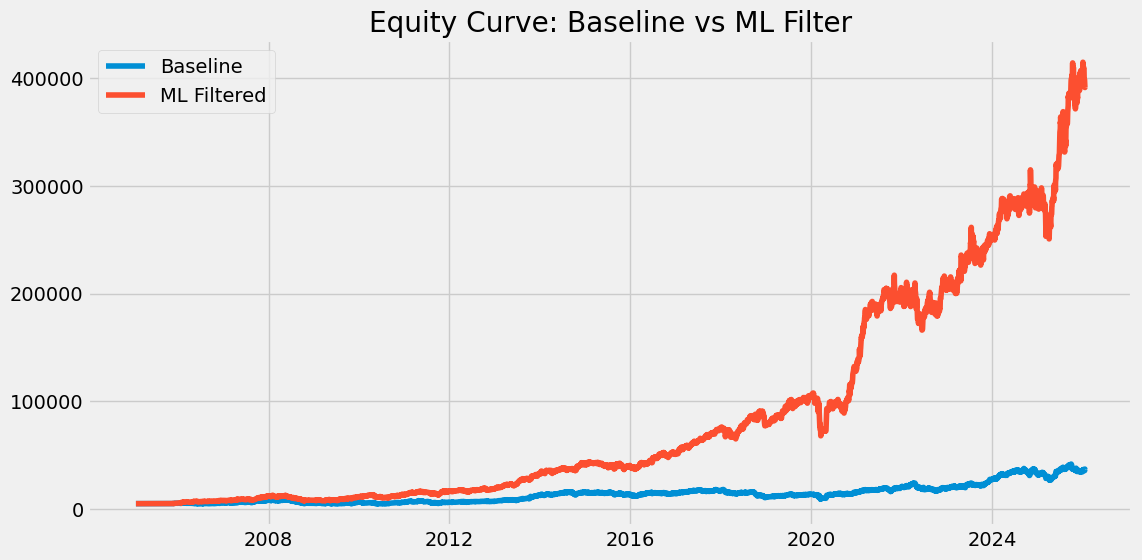

In [54]:
# models dict you already have
# models = {"Pullback": model_pb, "Breakout": model_bo, ...}

FEATURES = [
    "Score","RR","RiskPct","RS_Sec",
    "Rel_Vol","RSI","MACD_Hist","ADX",
    "ATR","ATR_Pct"
]

df_ml["p_win"] = np.nan

for sig, model in models.items():
    mask = df_ml["Signal"] == sig
    if mask.sum() == 0:
        continue

    X_sig = df_ml.loc[mask, FEATURES]
    df_ml.loc[mask, "p_win"] = model.predict_proba(X_sig)[:, 1]

TOP_PCT = 0.20  # 20%

df_ml["ml_selected"] = False

for (date, sig), g in df_ml.groupby(["Date", "Signal"]):
    if g["p_win"].isna().all():
        continue

    k = max(1, int(len(g) * TOP_PCT))
    top_idx = g.sort_values("p_win", ascending=False).head(k).index
    df_ml.loc[top_idx, "ml_selected"] = True

baseline_cands = df_ml.copy()
baseline_cands["take_trade"] = True

ml_cands = df_ml[df_ml["ml_selected"]].copy()
ml_cands["take_trade"] = True

def daily_candidates_from_df(date, df_source):
    day = df_source[df_source["Date"] == date]
    if day.empty:
        return pd.DataFrame()

    return day.sort_values(["Score","RR"], ascending=False)

# baseline: all candidates from df_ml
baseline_cands = df_ml.copy()

# ML filtered candidates: use your ml_selected column
ml_cands = df_ml[df_ml["ml_selected"]].copy()

trades_base, equity_base = run_backtest_10y(
    data_store=data_store,
    market_regime_us=MARKET_REGIME_US,
    market_regime_ca=MARKET_REGIME_CA,
    sector_performance_ts=sector_performance_ts,
    start_date=pd.Timestamp(START_DATE),
    end_date=pd.Timestamp(END_DATE),
    candidates_df=baseline_cands,     # ✅ use precomputed candidates
)

trades_ml, equity_ml = run_backtest_10y(
    data_store=data_store,
    market_regime_us=MARKET_REGIME_US,
    market_regime_ca=MARKET_REGIME_CA,
    sector_performance_ts=sector_performance_ts,
    start_date=pd.Timestamp(START_DATE),
    end_date=pd.Timestamp(END_DATE),
    candidates_df=ml_cands,           # ✅ ML-filtered candidates
)

metrics_base = backtest_metrics(trades_base, equity_base)
metrics_ml   = backtest_metrics(trades_ml, equity_ml)

print("Baseline trades:", len(trades_base))
print("ML trades:", len(trades_ml))
display(pd.DataFrame({"Baseline": metrics_base, "ML_Filtered": metrics_ml}))

compare = pd.DataFrame({
    "Baseline": metrics_base,
    "ML_Filtered": metrics_ml
})

display(compare)

plt.figure(figsize=(12,6))
plt.plot(equity_base["Date"], equity_base["Equity"], label="Baseline")
plt.plot(equity_ml["Date"], equity_ml["Equity"], label="ML Filtered")
plt.legend()
plt.title("Equity Curve: Baseline vs ML Filter")
plt.show()

